## prepare

In [2]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt


def load_all_data(folder_path, ignore_completed=False):
    """
    Iterate over all .json files in folder_path:
      - By default, include only those with quiz['completed'] == True;
      - Rename answer keys that have numeric suffixes (_1, _2, …)
      - Apply renaming logic for post-task-question and post-task-survey keys

    Returns a dict mapping each filename (without extension) to its processed quiz data dict.
    """
    def extract_suffix(key):
        m = re.search(r'_(\d+)$', key)
        return int(m.group(1)) if m else 0

    def remove_suffix(key):
        return re.sub(r'_(\d+)$', '', key)

    all_data = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.json'):
            continue
        path = os.path.join(folder_path, fn)
        try:
            with open(path, encoding='utf-8') as f:
                quiz = json.load(f)
        except json.JSONDecodeError:
            continue

        if not ignore_completed and not quiz.get('completed', False):
            continue

        key_name = os.path.splitext(fn)[0]
        all_data[key_name] = quiz

        answers = quiz.get('answers', {})
        if not isinstance(answers, dict):
            continue

        sorted_keys = sorted(answers.keys(), key=extract_suffix)
        new_answers = {}
        last_task = None
        for i, old in enumerate(sorted_keys):
            base = remove_suffix(old)

            if base == 'post-task-question':
                new_key = f"{last_task}_post-task-question" if last_task else base
            elif base.startswith('post-task-survey'):
                if i > 0:
                    prev = sorted_keys[i-1]
                    prev_base = remove_suffix(prev)
                    suffix = prev_base[prev_base.rfind('-'):] if '-' in prev_base else ''
                    new_key = base + suffix
                else:
                    new_key = base
                last_task = None
            else:
                new_key = base
                last_task = base

            new_answers[new_key] = answers[old]

        quiz['answers'] = new_answers

    return all_data

def time_analysis(all_data, metric='total_duration_min'):
    """
    Parameters:
      all_data (dict): The dictionary returned by load_quiz_data.

    Returns:
      df_task_level (pandas.DataFrame):
        A DataFrame with one row per task, including columns for start time, end time, duration, and format.
      df_participant_level (pandas.DataFrame):
        A DataFrame with one row per participant, including columns for total duration and format.
    """
    task_rows = []
    part_rows = []

    for fn, quiz in all_data.items():
        answers = quiz.get('answers', {})
        # look for participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get('answer', {})
                if isinstance(ans, dict) and 'prolificId' in ans:
                    pid = ans['prolificId']
                    break

        # extract  format
        current_format = None
        total_sec = 0
        temp = []
        for name, info in answers.items():
            if not isinstance(info, dict):
                continue
            st = info.get('startTime')
            ed = info.get('endTime')
            if st is not None and ed is not None:
                dur = (ed - st)/1000.0
            else:
                dur = None

            # tutorial-<fmt>-part1
            if current_format is None:
                m = re.match(r'tutorial-(\w+)-part1', name)
                if m:
                    current_format = m.group(1).lower()

            temp.append({
                'participantId': pid,
                'task': name,
                'startTime': st,
                'endTime': ed,
                'duration_sec': dur,
                'duration_min': dur/60 if dur is not None else None
            })
            if dur:
                total_sec += dur

        # add format 
        fmt = current_format or 'unknown'
        for row in temp:
            row['format'] = fmt
            task_rows.append(row)

        part_rows.append({
            'participantId': pid,
            'format': fmt,
            'duration_sec': round(total_sec,3),
            'duration_min': round(total_sec/60,2)
        })

    df_task = pd.DataFrame(task_rows)
    df_part = pd.DataFrame(part_rows)
    def clean(name, fmt):
        if fmt and fmt!='unknown':
            return name.replace(f"-{fmt}", "")
        return name

    df_task['task'] = df_task.apply(lambda r: clean(r['task'], r['format']), axis=1)
    format_stat = df_part['format'].value_counts()
    total_participant = len(df_part)
    print(f"Total number of valid participants: {total_participant}")

    return df_task, df_part, format_stat


import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/config'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/test_all_data'
all_data = load_all_data(folder, ignore_completed=True)
df_task, df_part, format_stat= time_analysis(all_data)

Total number of valid participants: 106


In [3]:
def _get_participant_id(answers: dict) -> str:
    for content in answers.values():
        if not isinstance(content, dict):
            continue
        ans = content.get('answer', {}) or {}
        if isinstance(ans, dict) and 'prolificId' in ans:
            return ans['prolificId']
    return None


def extract_writing_tasks(all_data: dict) -> pd.DataFrame:
    """
      - writing-task-NL
      - writing-task-tabular-<format>
      - modifying-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name == 'writing-task-NL' \
               or name.startswith('writing-task-tabular-') \
               or name.startswith('modifying-task-tabular-'):

                # format
                parts = name.split('-')
                if name == 'writing-task-NL':
                    fmt = 'NL'
                elif name.startswith('writing-task-tabular-'):
                    fmt = parts[-1]
                else:
                    fmt = parts[-2]

                # times
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None

                # code
                ans = content.get('answer', {}) or {}
                code = ans.get('code')

                # help clicks
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)


def extract_reading_tasks(all_data: dict) -> pd.DataFrame:
    """
      - reading-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      response, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('reading-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                num = parts[-1]

                # 回答键
                q_key = f"reading-task-tabular-{fmt}_q{num}"
                ans = content.get('answer', {}) or {}
                resp = ans.get(q_key)

                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'response':       resp,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)

def extract_writing_nl_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-NL 任务

    返回字段：participant_id, component, format='NL',
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        content = answers.get('writing-task-NL')
        if isinstance(content, dict):
            st = content.get('startTime')
            ed = content.get('endTime')
            dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
            ans = content.get('answer', {}) or {}
            code = ans.get('code')
            help_count = content.get('helpButtonClickedCount')
            rows.append({
                'participantId': pid,
                'task':      'writing-task-NL',
                'format':         'NL',
                'code':           code,
                'start_time':     st,
                'end_time':       ed,
                'duration_sec':   dur,
                'help_count':     help_count
            })
    return pd.DataFrame(rows)


def extract_writing_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-tabular-<format> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('writing-task-tabular-'):
                fmt = name.split('-')[-1]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)


def extract_modifying_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 modifying-task-tabular-<format>-<number> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('modifying-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)

def merge_dfs(df1: pd.DataFrame, df2: pd.DataFrame,
              on_cols: list, how: str = 'inner') -> pd.DataFrame:
    """
    根据指定列合并两个 DataFrame。

    参数：
      df1, df2: 待合并的 DataFrame
      on_cols:   用于合并的列名列表
      how:       合并方式，如 'inner', 'left', 'right', 'outer'

    返回合并后的 DataFrame。
    """
    merged = pd.merge(df1, df2, on=on_cols, how=how)
    return merged

# df_merged = merge_dfs(df1=df_tab_norm, df2=some_other_df,
#                       on_cols=['participant_id', 'format'],
#                       how='inner')

df_writing_nl = extract_writing_nl_tasks(all_data)
df_writing_tabular = extract_writing_tabular_tasks(all_data)
df_modifying_tabular = extract_modifying_tabular_tasks(all_data)
df_reading = extract_reading_tasks(all_data)


## data i will use

In [ ]:
df_writing_nl
df_writing_tabular
df_modifying_tabular
df_reading
format_stat

## writing analysis - time

In [4]:
def normalize_typing_time(df_nl: pd.DataFrame, df_tab: pd.DataFrame,
                          keep_baseline: bool = True) -> pd.DataFrame:

    # 1. 计算基线速度
    df_nl2 = df_nl.copy()
    df_nl2['char_count']   = df_nl2['code'].str.len()
    df_nl2['sec_per_char'] = df_nl2['duration_sec'] / df_nl2['char_count']

    # 2. 计算表格任务的预测耗时 & 速度比
    df_tab2 = df_tab.copy()
    df_tab2['char_count'] = df_tab2['code'].str.len()
    # 合并基线速度
    df_tab2 = df_tab2.merge(
        df_nl2[['participantId','sec_per_char']],
        on='participantId',
        how='left'
    )
    # 预测耗时
    df_tab2['predicted_time'] = df_tab2['char_count'] * df_tab2['sec_per_char']
    # 速度比：实际 / 预测
    df_tab2['speed_ratio']    = df_tab2['duration_sec'] / df_tab2['predicted_time']


    # 3. 返回
    if keep_baseline:
        return pd.concat([df_nl2, df_tab2], ignore_index=True, sort=False)
    else:
        return df_tab2


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.stats import levene, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def clean_task_column(
    df,
    task_col: str = 'task',
    format_col: str = 'format'
):
    """
    去除 df[task_col] 中末尾的 -<format> 后缀。
    
    例如：
      writing-task-tabular-json5 (format=json5) → writing-task-tabular
      reading-task-tabular-xml-1 (format=xml) → reading-task-tabular-1
    """
    df = df.copy()
    def _strip(row):
        task = row[task_col]
        fmt  = row[format_col]
        # 仅删除末尾的 -<fmt>
        return re.sub(f'-{re.escape(fmt)}$', '', task)
    df[task_col] = df.apply(_strip, axis=1)
    return df

def analyze_metric_differences(
    df: pd.DataFrame,
    task_col: str,
    group_col: str,
    metric_col: str,
    alpha: float = 0.05,
    clean_suffix: bool = True,
    figsize: tuple = (8, 4)
) -> pd.DataFrame:
    """
    按 task_col 分组，对 group_col 的 metric_col 做显著性检验并可视化。

    参数：
      df: 包含 task_col, group_col, metric_col 的 DataFrame
      task_col: 列名，用于分任务；可以自动去除 -format 后缀
      group_col: 列名，用于分组比较（如 format）
      metric_col: 列名，用作比较的指标
      alpha: 显著性水平
      clean_suffix: 是否先去除 task_col 中的 -<format> 后缀
      figsize: 绘图尺寸

    返回:
      DataFrame，包含每个 task 的:
        task, homogeneity_p, test, test_p, significant, posthoc
    """
    # 可选清理后缀
    if clean_suffix:
        df = clean_task_column(df, task_col=task_col, format_col=group_col)

    records = []
    for task in df[task_col].unique():
        sub = df[df[task_col] == task].dropna(subset=[metric_col])
        groups = sub[group_col].unique()
        # 至少两个组才能比较
        if len(groups) < 2:
            records.append({
                'task': task,
                'homogeneity_p': None,
                'test': None,
                'test_p': None,
                'significant': False,
                'posthoc': []
            })
            continue
        data_by_group = [sub.loc[sub[group_col] == g, metric_col].values for g in groups]

        # 1) Levene 检验
        _, p_lev = levene(*data_by_group)
        homogeneity = (p_lev >= alpha)

        # 2) 主效应检验
        if homogeneity:
            _, p_main = f_oneway(*data_by_group)
            test_name = 'ANOVA'
        else:
            try:
                _, p_main = kruskal(*data_by_group)
                test_name = 'Kruskal-Wallis'
            except ValueError as e:
                if 'All numbers are identical' in str(e):
                    p_main = 1.0
                    test_name = 'Kruskal-Wallis (identical)'
                else:
                    raise
        sig = (p_main < alpha)

        # 3) 事后分析
        posthoc = []
        if sig:
            if homogeneity:
                tukey = pairwise_tukeyhsd(endog=sub[metric_col], groups=sub[group_col], alpha=alpha)
                for row in tukey.summary().data[1:]:
                    g1, g2, *_, reject = row
                    if reject:
                        posthoc.append(f"{g1} vs {g2}")
            else:
                combs = list(itertools.combinations(groups, 2))
                alpha_adj = alpha / len(combs)
                for g1, g2 in combs:
                    d1 = sub.loc[sub[group_col] == g1, metric_col]
                    d2 = sub.loc[sub[group_col] == g2, metric_col]
                    _, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                    if p_u < alpha_adj:
                        posthoc.append(f"{g1} vs {g2}")

        # 4) 可视化箱型图
        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot(data_by_group, labels=groups, patch_artist=True)
        ax.set_title(f"{task} | {test_name} p={p_main:.3f} {'(sig)' if sig else '(ns)'}")
        ax.set_xlabel(group_col)
        ax.set_ylabel(metric_col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 5) 汇总记录
        records.append({
            'task': task,
            'homogeneity_p': p_lev,
            'test': test_name,
            'test_p': p_main,
            'significant': sig,
            'posthoc': posthoc
        })

    return pd.DataFrame(records)

import re
import pandas as pd
from scipy.stats import zscore
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMResults

def add_speed_zscore(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    speed_col: str = 'speed_ratio'
) -> pd.DataFrame:
    df2 = df.copy()
    df2['speed_zscore'] = (
        df2
        .groupby(participant_col)[speed_col]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )
    return df2

def fit_mixed_effects_speed(
    df: pd.DataFrame,
    speed_col: str = 'speed_zscore',
    format_col: str = 'format',
    participant_col: str = 'participant_id'
) -> MixedLMResults:
    df2 = df.copy()
    df2[format_col] = df2[format_col].astype('category')
    formula = f"{speed_col} ~ C({format_col})"
    model = smf.mixedlm(formula, df2, groups=df2[participant_col])
    return model.fit()

# # 先生成 z-score
# df_speed_z = add_speed_zscore(
#     df_tab_norm,
#     participant_col='participantId',
#     speed_col='speed_ratio'
# )

# # 然后用 speed_zscore 拟合
# mixed_res = fit_mixed_effects_speed(
#     df_speed_z,
#     speed_col='speed_ratio',
#     format_col='format',
#     participant_col='participantId'
# )
# print(mixed_res.summary())

# df_tab_norm_clean = clean_task_column(df_tab_norm, task_col='task', format_col='format')


## show writing results - time

In [6]:
df_tab_norm = normalize_typing_time(df_writing_nl, df_writing_tabular, keep_baseline=False)

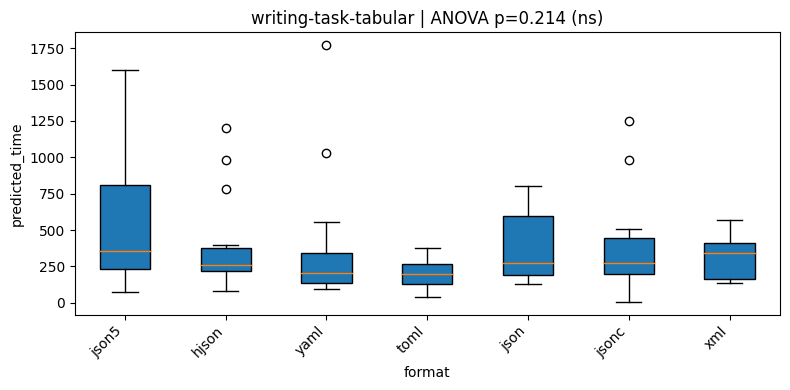

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.201259,ANOVA,0.213504,False,[]


In [7]:
summary_writing_ptime = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='predicted_time',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_ptime

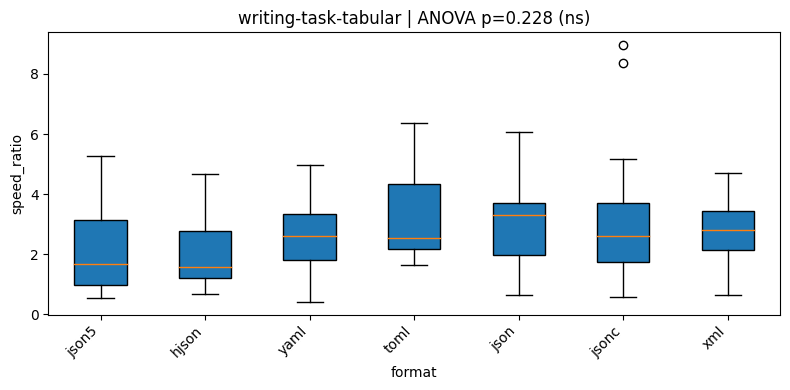

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.395421,ANOVA,0.228037,False,[]


In [8]:
summary_writing_sr = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='speed_ratio',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_sr

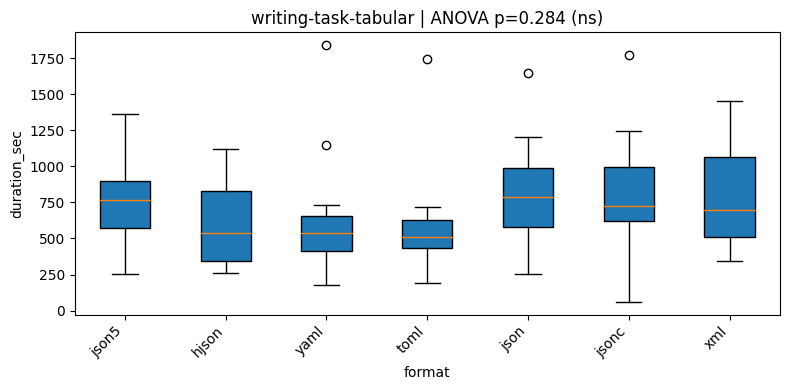

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.939824,ANOVA,0.284465,False,[]


In [9]:
summary_writing_atime = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_atime

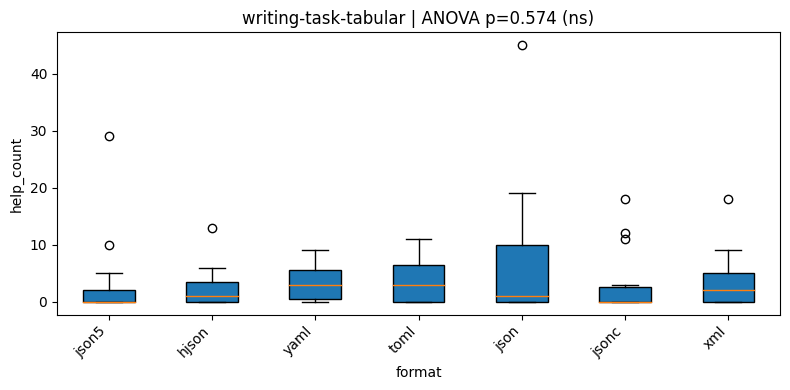

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.441093,ANOVA,0.574159,False,[]


In [10]:
summary_writing_help = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_help

## reading/modifying analysis - time

In [12]:
import re
import pandas as pd

def aggregate_tasks_with_format(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col: str = 'task',
    format_col: str = 'format',
    metrics: list = ['duration_sec', 'help_count']
) -> pd.DataFrame:
    """
    对形如 <prefix>-<format>-<number> 的子任务：
      1) 清理中间 '-<format>'，如 reading-task-tabular-json5-1 → reading-task-tabular-1
      2) 生成汇总行（<prefix>），将同 participant+format 下所有数字后缀子任务的 metrics 求和，
         并保留 format

    参数:
      df            包含 participant_id, task, format, metrics 列的 DataFrame
      participant_col: 列名，参与者 ID
      task_col:        列名，任务名称
      format_col:      列名，格式名称
      metrics:         需要聚合的列

    返回:
      DataFrame：包含原始子任务行 + 聚合行，聚合行的 task 列为 prefix（去掉数字后缀）
    """
    df = df.copy()
    # 1) 去掉中间 '-<format>'，仅针对末尾带数字后缀的任务
    def strip_format(task, fmt):
        # pattern: -<fmt> before -number
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df[task_col] = df.apply(lambda row: strip_format(row[task_col], str(row[format_col])), axis=1)

    # 2) 筛选出带数字后缀的子任务
    mask = df[task_col].str.contains(r"-\d+$", regex=True)
    sub = df[mask].copy()

    # 3) 计算 prefix = 去掉尾部 '-number'
    sub_prefix = sub.copy()
    sub_prefix[task_col] = sub_prefix[task_col].str.replace(r"-\d+$", "", regex=True)

    # 4) 按 participant_id + format + prefix 聚合 metrics
    agg = (
        sub_prefix
        .groupby([participant_col, format_col, task_col], as_index=False)[metrics]
        .sum()
    )

    # 5) 合并原始行和聚合行
    result = pd.concat([df, agg], ignore_index=True, sort=False)
    return result



## show reading/modifying results -time

In [13]:

df_reading_clean = aggregate_tasks_with_format(
    df_reading,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

df_modifying_clean = aggregate_tasks_with_format(
    df_modifying_tabular,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

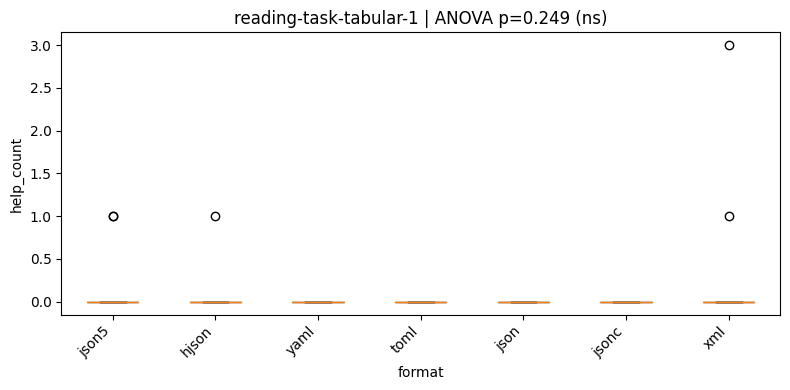

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


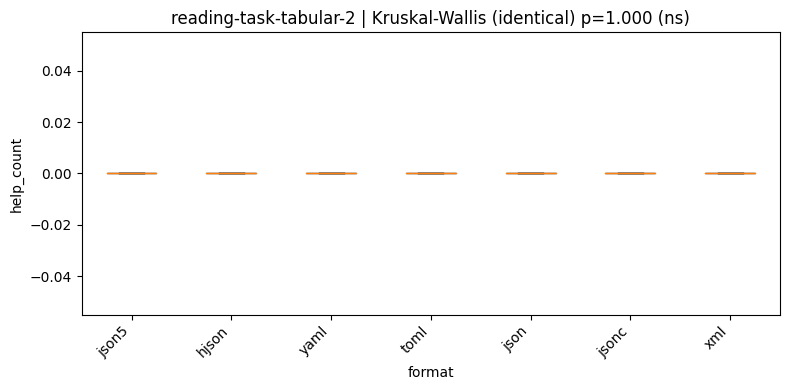

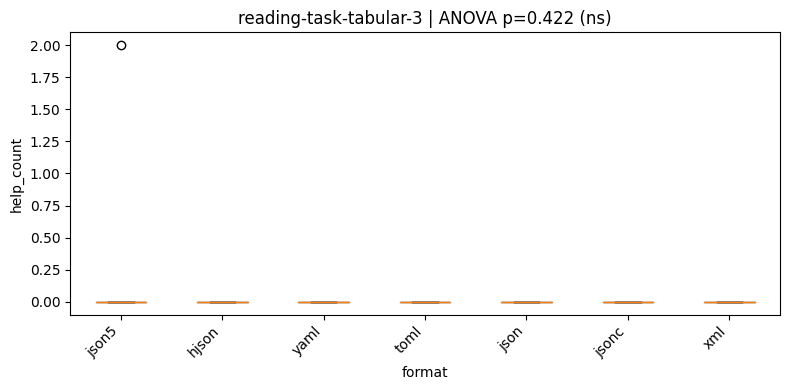

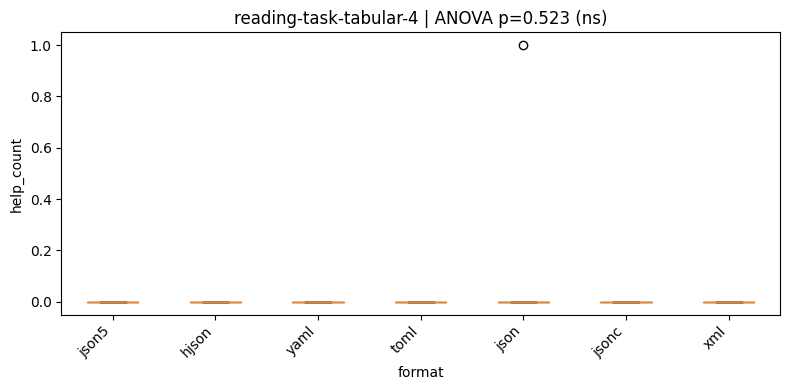

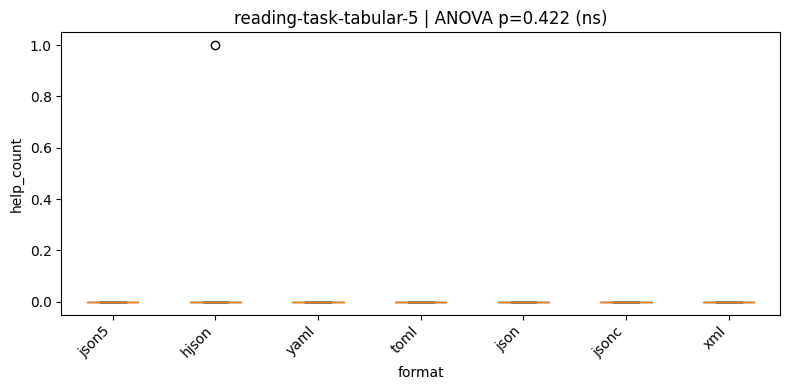

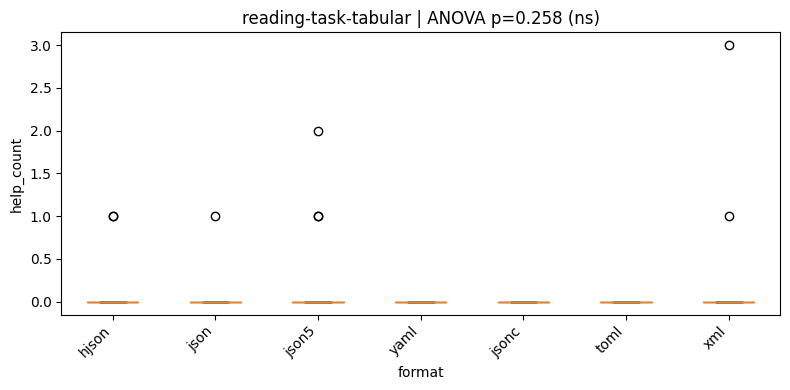

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.249339,ANOVA,0.249339,False,[]
1,reading-task-tabular-2,NaN,Kruskal-Wallis (identical),1.000000,False,[]
2,reading-task-tabular-3,0.422121,ANOVA,0.422121,False,[]
3,reading-task-tabular-4,0.522879,ANOVA,0.522879,False,[]
4,reading-task-tabular-5,0.422121,ANOVA,0.422121,False,[]
5,reading-task-tabular,0.257991,ANOVA,0.257991,False,[]


In [14]:
summary_reading_help = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True 
)

summary_reading_help

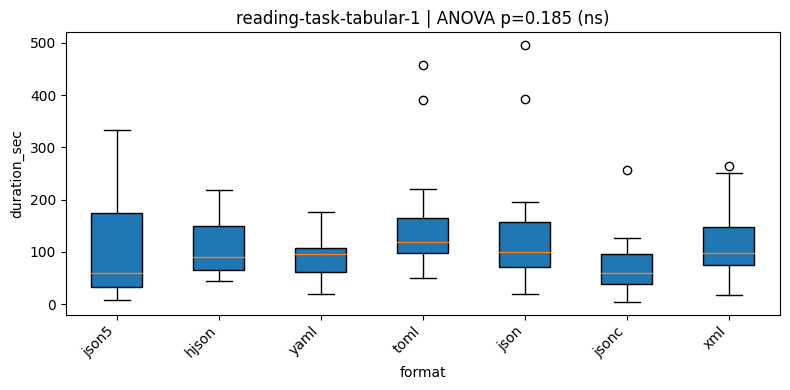

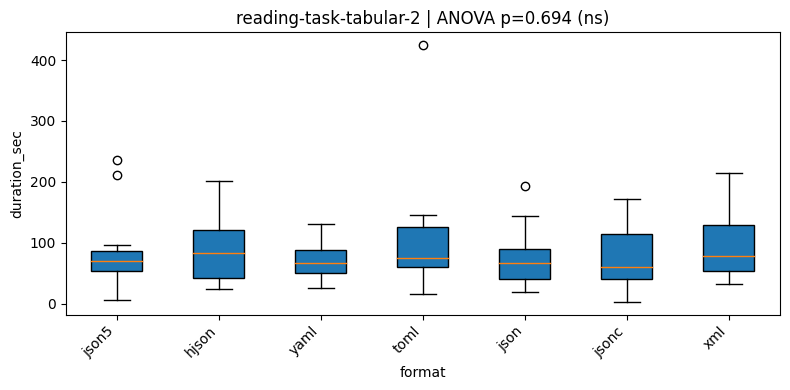

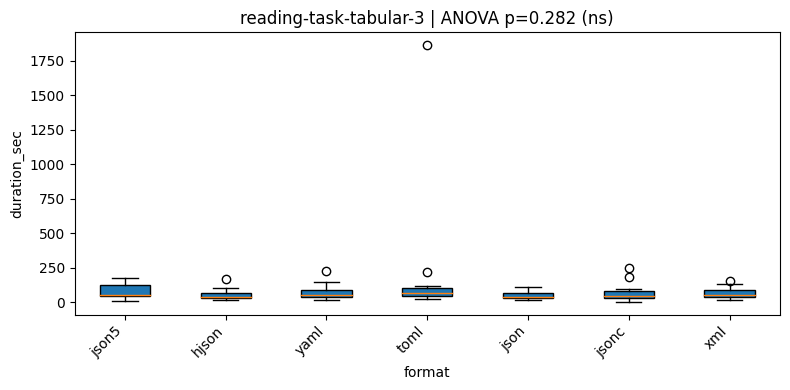

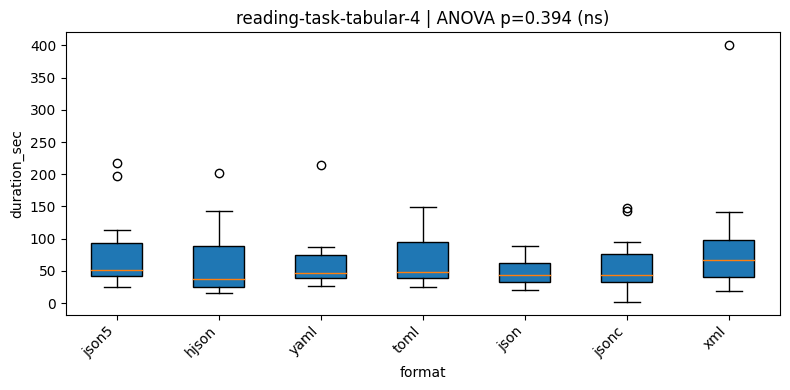

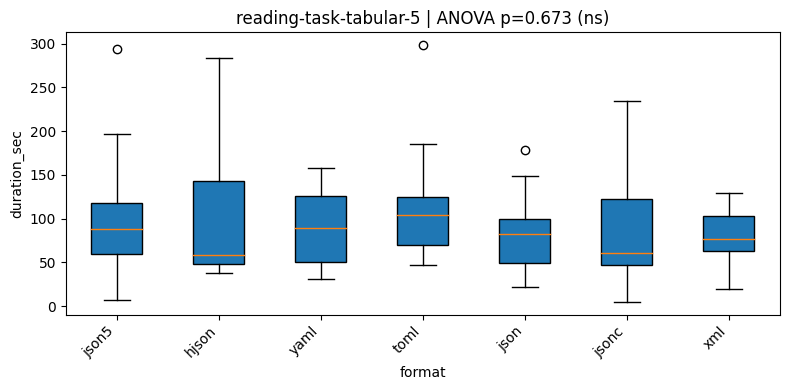

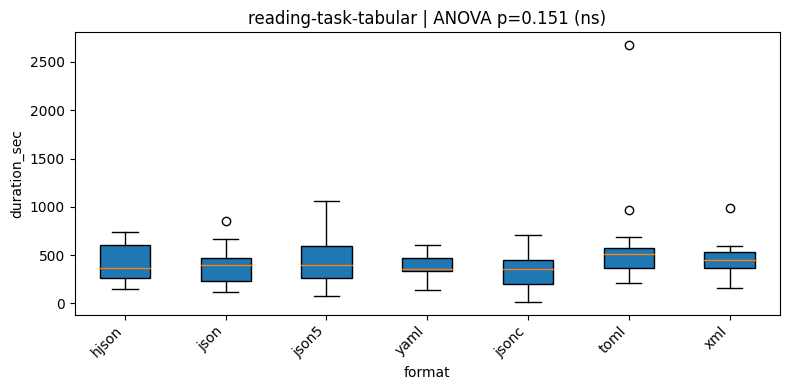

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.338326,ANOVA,0.185309,False,[]
1,reading-task-tabular-2,0.732178,ANOVA,0.694480,False,[]
2,reading-task-tabular-3,0.348505,ANOVA,0.282461,False,[]
3,reading-task-tabular-4,0.558429,ANOVA,0.394428,False,[]
4,reading-task-tabular-5,0.495129,ANOVA,0.672755,False,[]
5,reading-task-tabular,0.465146,ANOVA,0.151016,False,[]


In [15]:
summary_reading_time = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_reading_time

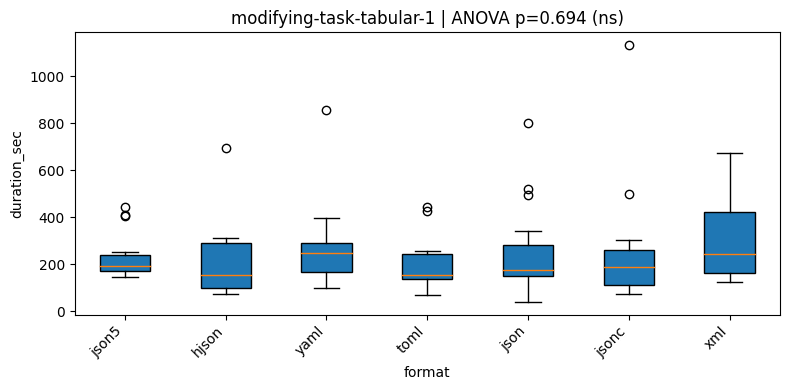

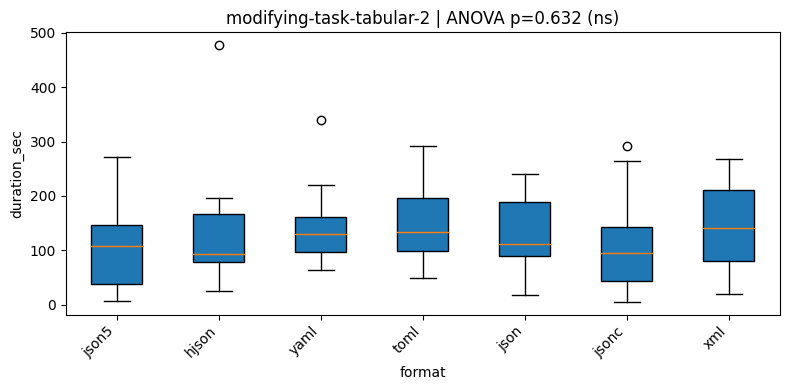

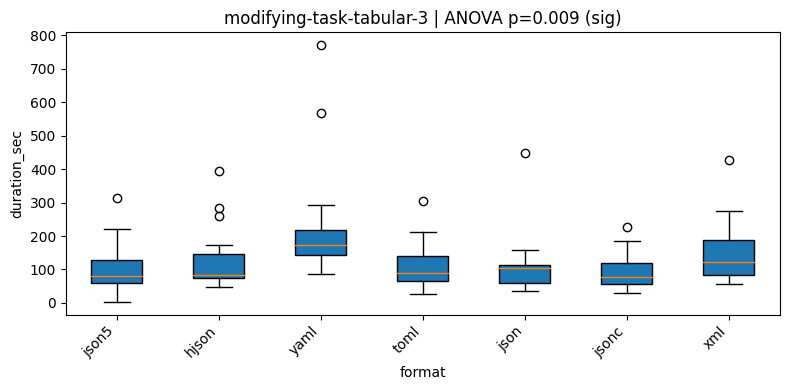

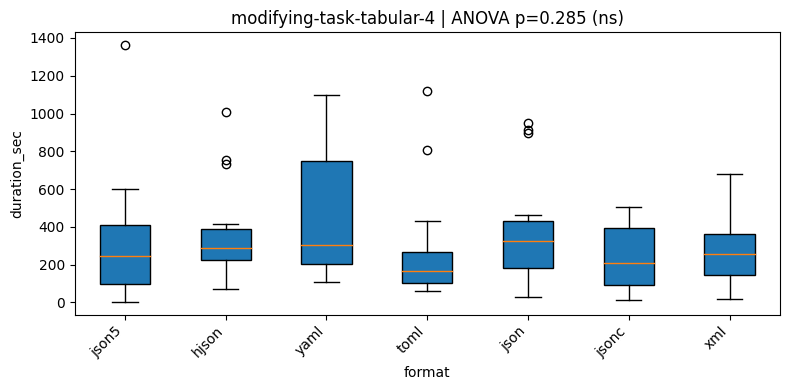

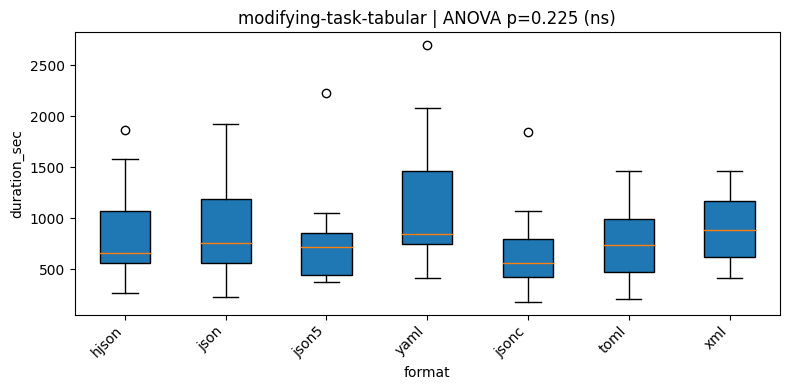

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.789678,ANOVA,0.693573,False,[]
1,modifying-task-tabular-2,0.988812,ANOVA,0.632126,False,[]
2,modifying-task-tabular-3,0.554342,ANOVA,0.009062,True,"[json vs yaml, json5 vs yaml, jsonc vs yaml, t..."
3,modifying-task-tabular-4,0.740686,ANOVA,0.285302,False,[]
4,modifying-task-tabular,0.830471,ANOVA,0.225203,False,[]


In [16]:
summary_modifying_time = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_modifying_time

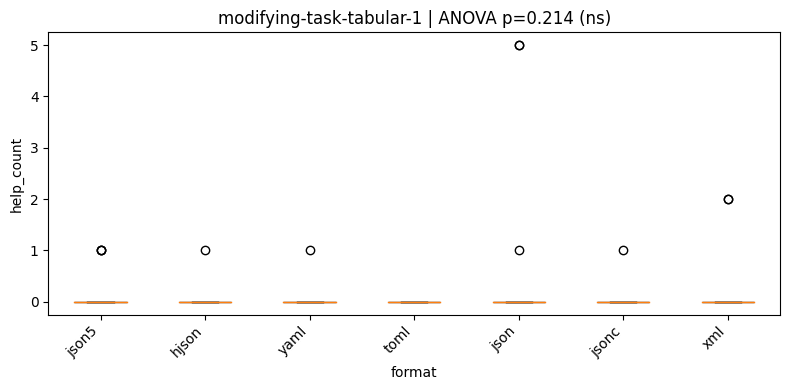

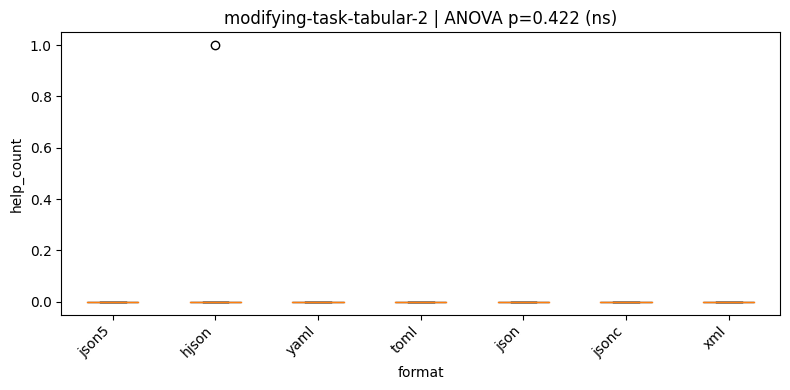

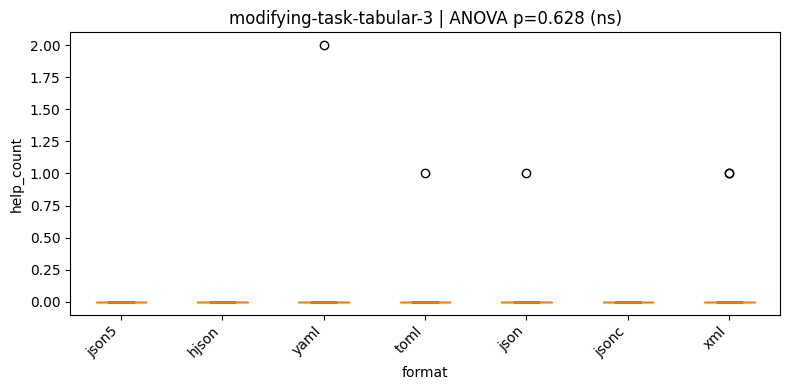

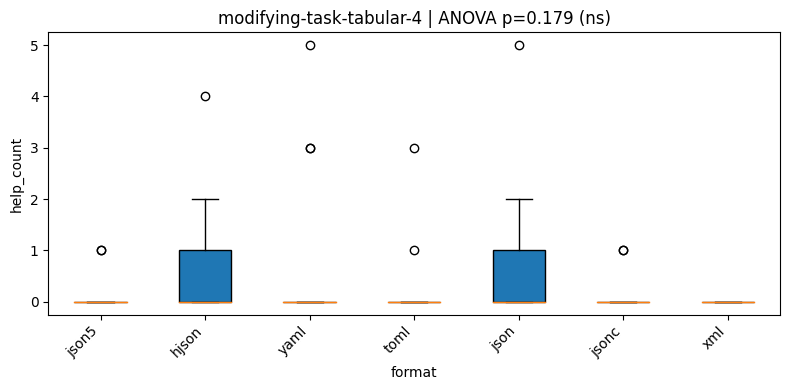

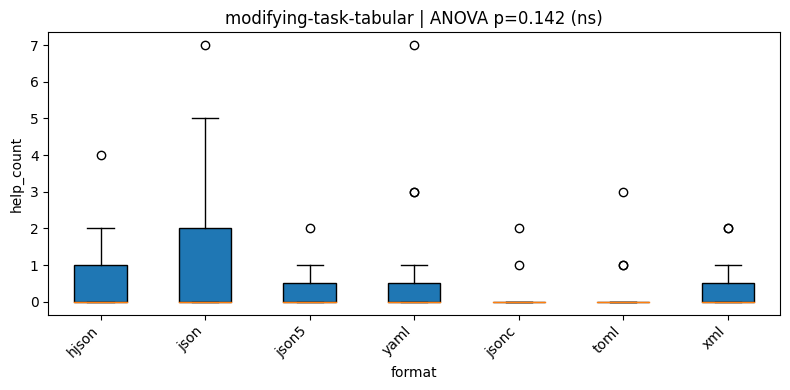

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.214148,ANOVA,0.214148,False,[]
1,modifying-task-tabular-2,0.422121,ANOVA,0.422121,False,[]
2,modifying-task-tabular-3,0.627621,ANOVA,0.627621,False,[]
3,modifying-task-tabular-4,0.178922,ANOVA,0.178922,False,[]
4,modifying-task-tabular,0.141615,ANOVA,0.141615,False,[]


In [17]:
summary_modifying_help = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_modifying_help

## reading analysis - correctness

In [20]:
def _normalize(val: any) -> str:
    """
    基础规范化：
      - 转成 str
      - 折叠空白
      - strip
      - lower
    """
    s = str(val)
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()


def annotate_reading_correctness_exact(
    df: pd.DataFrame,
    correct_answers: dict,
    task_col: str     = 'task',
    format_col: str   = 'format',
    response_col: str = 'response'
) -> pd.DataFrame:
    """
    精确匹配阅读题答案：
    - correct_answers[key] 为单值或列表，值可以是类似 '[Bob, Eve]' 或 'Alice'
    - 只当用户作答完全等于某一选项（单选或多选整体）时，才算正确

    对于用户 response：
      - 若为 list/tuple，则视为多选，multiple_norm = ','.join(norm(item))
      - 若单值或字符串，则单选，item_norm = norm(item)
    将正确答案列表中的每一项：
      - 把外层方括号去掉得到 inner = strip_brackets(ans)
      - norm(inner) 作为候选 multi_norm
      - norm(ans) 作为候选 single_norm

    匹配规则：
      - 如果是多选（len>1），比较 multi_norm 是否在候选 multi_norms
      - 如果是单选，则比较 item_norm 是否在候选 single_norms

    返回含新增两列的 DataFrame：
      - correct_answer: 原始候选拼接字符串
      - correct: 0/1
    """
    df2 = df.copy()
    ans_col = []
    flag_col = []

    for _, row in df2.iterrows():
        # 清理 key
        orig_task = str(row[task_col])
        fmt = str(row[format_col])
        clean_key = re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", orig_task)
        raw = correct_answers.get(clean_key, correct_answers.get(orig_task, []))
        if not isinstance(raw, (list, tuple)):
            raw = [raw]
        # display
        ans_col.append(", ".join(str(x) for x in raw)
        )
        # build candidate norms
        single_norms = set()
        multi_norms  = set()
        for cand in raw:
            cand_str = str(cand)
            # inner = remove outer brackets
            inner = re.sub(r"^\s*\[|\]\s*$", "", cand_str)
            # normalize
            sn = _normalize(inner)
            single_norms.add(sn)
            # multi_norm uses commas
            parts = [_normalize(x) for x in inner.split(',')]
            mn = ",".join(parts)
            multi_norms.add(mn)

        # process response
        resp = row[response_col]
        # if list/tuple -> multi, else single
        if isinstance(resp, (list, tuple)):
            parts = [_normalize(x) for x in resp]
            resp_norm = ",".join(parts)
            hit = resp_norm in multi_norms
        else:
            r = str(resp)
            # remove brackets if any
            r_inner = re.sub(r"^\s*\[|\]\s*$", "", r)
            r_norm = _normalize(r_inner)
            hit = r_norm in single_norms
        flag_col.append(int(hit))

    df2['correct_answer'] = ans_col
    df2['correct'] = flag_col
    return df2

def aggregate_tasks_with_format(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col:        str = 'task',
    format_col:      str = 'format',
    sum_cols:        list = None,
    mean_cols:       list = None
) -> pd.DataFrame:
    """
    对形如 <prefix>-<format>-<number> 的子任务做聚合：
      1) 清理中间 '-<format>'，如 'reading-task-tabular-json5-1' → 'reading-task-tabular-1'
      2) 生成汇总行（<prefix>），按 participant+format 聚合：
         - 对 sum_cols 列做 sum
         - 对 mean_cols 列做 mean
         并保留 format 列

    参数:
      df             原始 DataFrame，需包含 participant_col, task_col, format_col
      participant_col: 参与者 ID 列名
      task_col:        任务名称 列名
      format_col:      格式 列名
      sum_cols:        需要求和的列列表（如 ['duration_sec','help_count']）
      mean_cols:       需要取平均的列列表（如 ['correct']）

    返回:
      包含原始子任务行 + 汇总行的 DataFrame，汇总行的 task_col 为 prefix（去掉数字后缀）
    """
    df2 = df.copy()
    sum_cols = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 清理 '-<format>'
    def _strip_fmt(task, fmt):
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df2[task_col] = df2.apply(
        lambda r: _strip_fmt(r[task_col], str(r[format_col])),
        axis=1
    )

    # 2) 筛选子任务
    mask = df2[task_col].str.contains(r"-\d+$", regex=True)
    sub = df2[mask].copy()

    # 3) 构造 prefix
    sub_prefix = sub.copy()
    sub_prefix[task_col] = sub_prefix[task_col].str.replace(r"-\d+$", "", regex=True)

    # 4) 构建聚合映射
    agg_map = {c: 'sum' for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 5) 聚合
    agg = (
        sub_prefix
        .groupby([participant_col, format_col, task_col], as_index=False)
        .agg(agg_map)
    )

    # 6) 合并并返回
    result = pd.concat([df2, agg], ignore_index=True, sort=False)
    return result


## show reading results - correctness

In [21]:
df_reading_clean = clean_task_column(df_reading, task_col='task', format_col='format')

correct_answers = {
    'reading-task-tabular-1': 87,
    'reading-task-tabular-2': 'quiz2',
    'reading-task-tabular-3': 4,
    'reading-task-tabular-4': 'Bob',
    'reading-task-tabular-5': ['[Bob, Eve]', '[Alice]']
}

df_reading_clean = clean_task_column(df_reading, task_col='task', format_col='format')

df_reading_result = annotate_reading_correctness_exact(
    df_reading_clean,
    correct_answers,
    task_col='task',
    format_col='format',
    response_col='response'
)

df_reading_agg = aggregate_tasks_with_format(
    df_reading_result,
    participant_col='participantId',
    task_col='task',
    format_col='format',
    sum_cols=['duration_sec','help_count'],
    mean_cols=['correct']
)
df_reading_agg

,participantId,task,format,response,start_time,end_time,duration_sec,help_count,correct_answer,correct
0,64457bc906c125cebd4bf66b,reading-task-tabular-1,json5,9,1.746560e+12,1.746560e+12,14.824,0,87,0.0
1,64457bc906c125cebd4bf66b,reading-task-tabular-2,json5,quiz2,1.746560e+12,1.746560e+12,72.466,0,quiz2,1.0
2,64457bc906c125cebd4bf66b,reading-task-tabular-3,json5,4,1.746560e+12,1.746560e+12,24.606,0,4,1.0
3,64457bc906c125cebd4bf66b,reading-task-tabular-4,json5,Bob,1.746560e+12,1.746560e+12,26.410,0,Bob,1.0
4,64457bc906c125cebd4bf66b,reading-task-tabular-5,json5,[Eve],1.746560e+12,1.746560e+12,96.426,0,"[Bob, Eve], [Alice]",0.0
...,...,...,...,...,...,...,...,...,...,...
631,67f1a4f8dd44e7cd5adffa29,reading-task-tabular,json5,NaN,NaN,NaN,1056.874,0,NaN,1.0
632,67f1c7bd6f1c4a3d8deae02f,reading-task-tabular,toml,NaN,NaN,NaN,577.437,0,NaN,0.8
633,67f3619e16d4ca195fbd1bd0,reading-task-tabular,yaml,NaN,NaN,NaN,603.879,0,NaN,0.6
634,67f5bb69760b211cdfe8021c,reading-task-tabular,jsonc,NaN,NaN,NaN,173.583,0,NaN,0.8


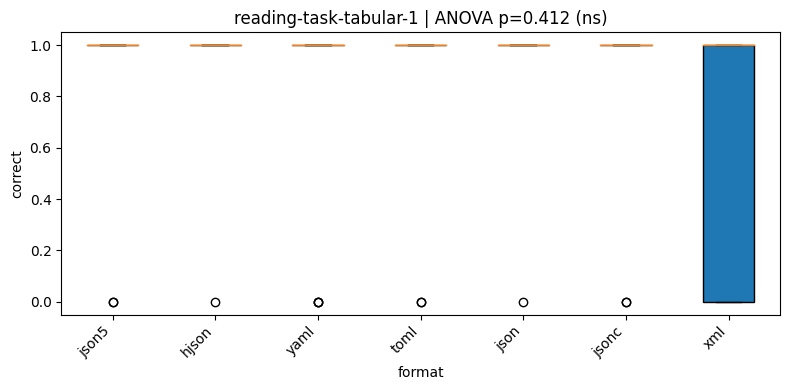

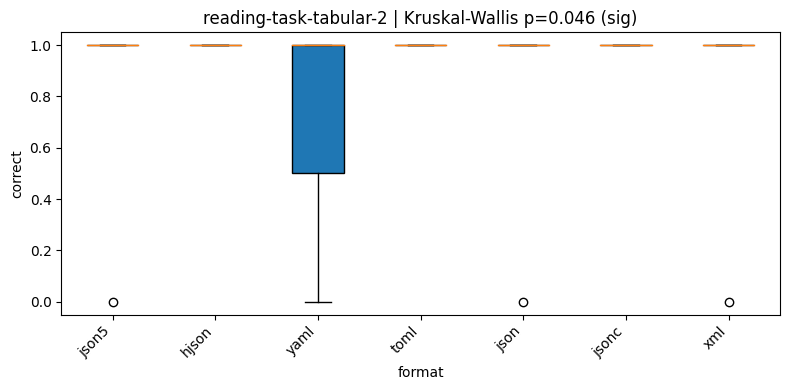

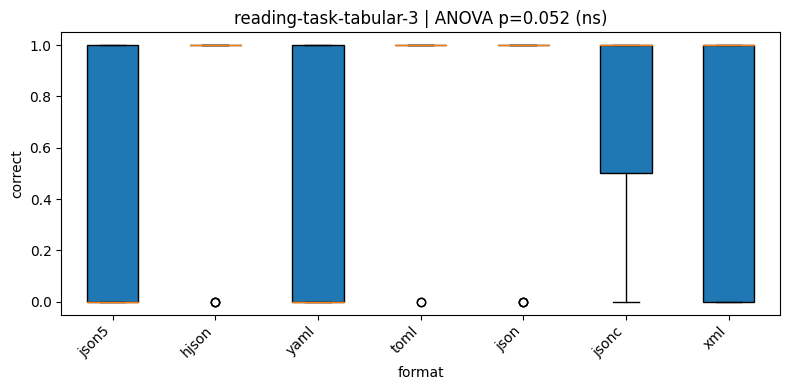

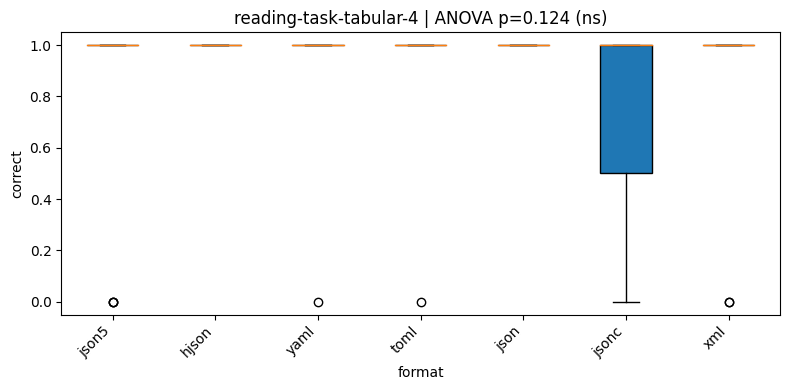

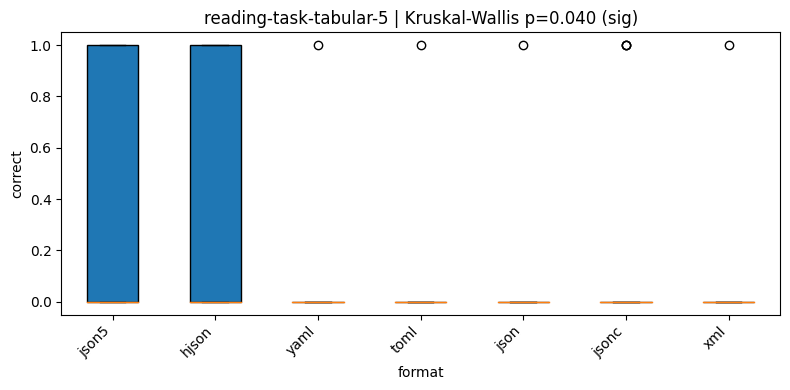

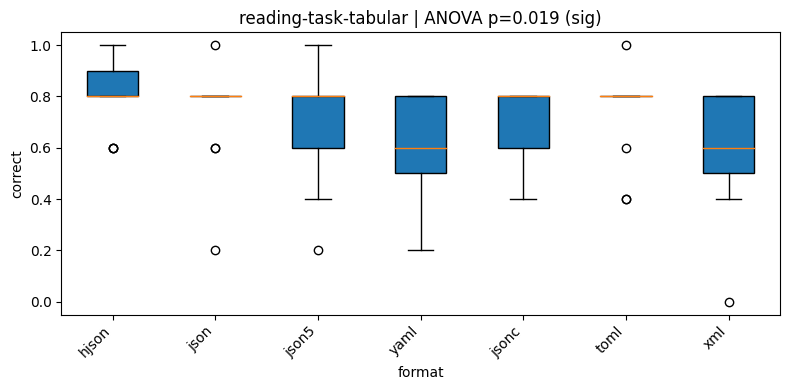

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.412305,ANOVA,0.412305,False,[]
1,reading-task-tabular-2,0.041199,Kruskal-Wallis,0.046440,True,[]
2,reading-task-tabular-3,0.155270,ANOVA,0.052135,False,[]
3,reading-task-tabular-4,0.124492,ANOVA,0.124492,False,[]
4,reading-task-tabular-5,0.035401,Kruskal-Wallis,0.040486,True,[]
5,reading-task-tabular,0.337565,ANOVA,0.018665,True,"[hjson vs xml, hjson vs yaml]"


In [22]:
summary_reading_correct = analyze_metric_differences(
    df=df_reading_agg,
    task_col='task',
    group_col='format',
    metric_col='correct',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_reading_correct

## quiz analysis

In [24]:
import re
import pandas as pd

def aggregate_quiz_parts(
    df: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col: str = 'format',
    task_col: str = 'quiz_key',
    sum_cols: list = None,
    mean_cols: list = None
) -> pd.DataFrame:
    """
    将 quiz_key 中的 part1/part2 聚合为不带后缀的基准任务并追加到原表：
      tutorial-json5-part1 & tutorial-json5-part2 -> tutorial-json5

    对于聚合后的每条记录：
      - 对 sum_cols 指定的列做求和
      - 对 mean_cols 指定的列做平均

    参数:
      df            原始 quiz DataFrame，需包含 participant_col, format_col, task_col
      participant_col: 参与者 ID 列名
      format_col:      格式 列名
      task_col:        任务列名（如 'quiz_key'），形如 'tutorial-json5-part1'
      sum_cols:        需要合并求和的列名列表（如 ['num_wrong_attempts','wrong_choice_count']）
      mean_cols:       需要合并取平均的列名列表（如 ['correct']）

    返回:
      原始行 + 聚合行组成的 DataFrame，聚合行的 task_col 为 'tutorial-json5',
      sum_cols 做 sum，mean_cols 做 mean。
    """
    df2 = df.copy()
    sum_cols = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 计算基准任务名：去掉末尾 '-part1' 或 '-part2'
    base = df2[task_col].str.replace(r'-part[12]$', '', regex=True)

    # 2) 构建聚合映射
    agg_map = {c: 'sum' for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 3) 按 participant, format, base 进行聚合
    agg = (
        df2.assign(**{'_base': base})
           .groupby([participant_col, format_col, '_base'], as_index=False)
           .agg(agg_map)
           .rename(columns={'_base': task_col})
    )

    # 4) 合并 原始行 + 聚合行，不改变原始数据
    combined = pd.concat([df2, agg], ignore_index=True, sort=False)
    return combined


def summarize_quiz_parts(
    df: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col:    str = 'format',
    task_col:      str = 'quiz_key',
    sum_cols:      list = None,
    mean_cols:     list = None
) -> pd.DataFrame:
    """
    只提取 quiz_key 中 part1/part2 聚合后的基准任务行：
      tutorial-json5-part1 & tutorial-json5-part2 -> tutorial-json5

    聚合规则：
      - 对 sum_cols 指定的列做求和
      - 对 mean_cols 指定的列做平均

    返回一个 DataFrame，列为:
      [participant_col, format_col, task_col] + sum_cols + mean_cols
    其中 task_col 已被替换成去掉 '-part1/2' 的基准任务名。
    """
    df2 = df.copy()
    sum_cols  = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 先生成“基准任务名”：去掉尾部 '-part1' 或 '-part2'
    base = df2[task_col].str.replace(r'-part[12]$', '', regex=True)

    # 2) 构建聚合映射
    agg_map = {c: 'sum'  for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 3) 分组并聚合，只保留汇总行
    agg = (
        df2
        .assign(_base=base)
        .groupby([participant_col, format_col, '_base'], as_index=False)
        .agg(agg_map)
        .rename(columns={'_base': task_col})
    )

    # 4) 返回聚合结果
    return agg

import re
import pandas as pd

def analyze_metric_by_base_task(
    df: pd.DataFrame,
    task_col: str,
    format_col: str,
    metric_col: str,
    participant_col: str = None,
    alpha: float = 0.05,
    base_task_col: str = None,
    **analyze_kwargs
) -> pd.DataFrame:

    df2 = df.copy()
    # 1) 决定新列名
    if base_task_col is None:
        base_task_col = f"{task_col}_base"

    # 2) 去掉尾部 "-<format>"
    #    e.g. "tutorial-json5-part1" -> "tutorial-json5-part1" minus "-json5" -> "tutorial-part1"
    pattern = fr"-{re.escape(str(df2[format_col].iat[0]))}$"
    # but since each row may have different format, do apply:
    df2[base_task_col] = df2.apply(
        lambda r: re.sub(fr"-{re.escape(str(r[format_col]))}$", "", str(r[task_col])),
        axis=1
    )

    # 3) 调用你已有的 analyze_metric_differences
    #    记得把 clean_suffix 关掉，因为我们自己做了清理

    summary = analyze_metric_differences(
        df = df2,
        task_col   = base_task_col,
        group_col  = format_col,
        metric_col = metric_col,
        alpha      = alpha,
        clean_suffix = True,
        **analyze_kwargs
    )
    return summary


## show quiz results

In [25]:
from quiz_evaluator import evaluate_quiz_answers_from_tutorial

df_quiz = evaluate_quiz_answers_from_tutorial(all_data)
df_quiz_agg = aggregate_quiz_parts(
    df_quiz,
    participant_col='participantId',
    format_col='format',
    task_col='quiz_key',
    sum_cols=['num_wrong_attempts', 'wrong_choice_count'],
    mean_cols=['correct']
)


df_quiz_summary = summarize_quiz_parts(
    df_quiz,
    participant_col='participantId',
    format_col='format',
    task_col='quiz_key',
    sum_cols=['num_wrong_attempts','wrong_choice_count'],
    mean_cols=['correct']
)

df_quiz_summary

,participantId,format,quiz_key,num_wrong_attempts,wrong_choice_count,correct
0,56cb8858edf8da000b6df354,hjson,tutorial-hjson,0,0,1.0
1,57c357770e6a1f00015f6038,json,tutorial-json,1,1,1.0
2,5b68c9eb87af310001584803,json5,tutorial-json5,3,2,1.0
3,5d30dfa68b1523000134878f,json,tutorial-json,3,6,1.0
4,5d766978f47e6200019a2acf,yaml,tutorial-yaml,2,1,1.0
...,...,...,...,...,...,...
101,67f1a4f8dd44e7cd5adffa29,json5,tutorial-json5,3,5,1.0
102,67f1c7bd6f1c4a3d8deae02f,toml,tutorial-toml,0,0,1.0
103,67f3619e16d4ca195fbd1bd0,yaml,tutorial-yaml,3,1,1.0
104,67f5bb69760b211cdfe8021c,jsonc,tutorial-jsonc,5,0,0.5


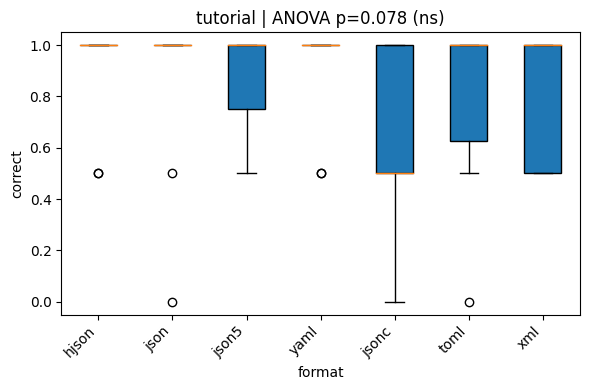

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.109688,ANOVA,0.078171,False,[]


In [26]:
# 假设 df_quiz_combined 已含 tutorial-json5, tutorial-hjson ... 以及 correct
summary_quiz = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'correct',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz

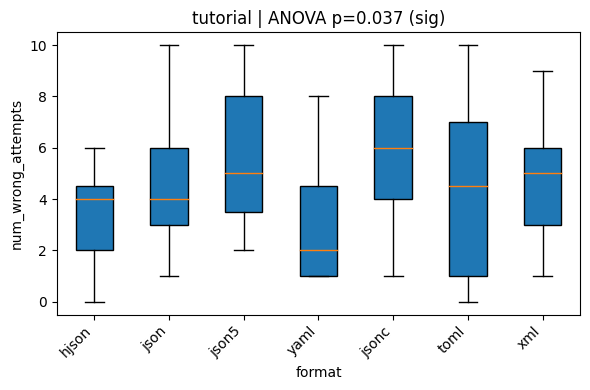

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.322153,ANOVA,0.037066,True,[]


In [27]:
summary_quiz_wrongAtp = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'num_wrong_attempts',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_wrongAtp

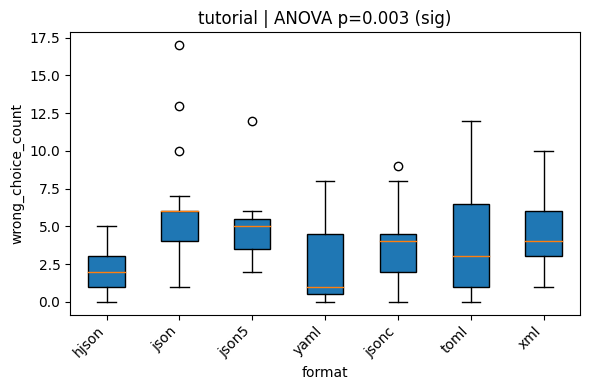

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.245063,ANOVA,0.00268,True,"[hjson vs json, json vs yaml]"


In [28]:
summary_quiz_wrongCho = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'wrong_choice_count',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_wrongCho

## nasaltx analysis

In [30]:
import pandas as pd

def melt_tlx(
    df: pd.DataFrame,
    id_vars: list = None,
    tlx_vars: list = None,
    var_name: str = 'task',
    value_name: str = 'score'
) -> pd.DataFrame:
    """
    将 NASA-TLX 六个维度从宽表转成长表：
      mental-demand, physical-demand, temporal-demand,
      performance, effort, frustration
    会被融入一列 `var_name`，对应的数值列为 `value_name`。

    参数:
      df:        原始 DataFrame，需含上述维度列
      id_vars:   保留作为标识符的列列表，默认 ['participantId','format','startTime','endTime','duration_sec']
      tlx_vars:  待转换的列列表，默认上述六个
      var_name:  新列名，存放原列名
      value_name:新列名，存放原值

    返回:
      长表格式的 DataFrame，列为 id_vars + [var_name, value_name]
    """
    # 默认保留列
    if id_vars is None:
        id_vars = ['participantId', 'format', 'startTime', 'endTime', 'duration_sec']
    # 默认待融入列
    if tlx_vars is None:
        tlx_vars = [
            'mental-demand',
            'physical-demand',
            'temporal-demand',
            'performance',
            'effort',
            'frustration',
        ]
    # 使用 pandas.melt
    df_long = df.melt(
        id_vars=id_vars,
        value_vars=tlx_vars,
        var_name=var_name,
        value_name=value_name
    )
    return df_long


## show nasatlx results

In [31]:
from quiz_evaluator import analyze_nasa_and_post_surveys

# 假设 all_data 已加载
df_nasa = analyze_nasa_and_post_surveys(all_data)
df_nasa['task']='nasaltx'
df_nasa_tidy = melt_tlx(df_nasa)
df_nasa_tidy

,participantId,format,startTime,endTime,duration_sec,task,score
0,64457bc906c125cebd4bf66b,json5,1746562427809,1746562451027,23.218,mental-demand,93
1,6697c8b6d9d7baa7edd8c4d3,hjson,1745933947314,1745933980430,33.116,mental-demand,90
2,67e25388d573ec2d5f1c8442,yaml,1746148170240,1746148206380,36.140,mental-demand,90
3,67e5cf90b79d0874e1cf16b0,toml,1746147492250,1746147510048,17.798,mental-demand,97
4,67d00f24466a67ba7e41228e,toml,1745933364792,1745933382986,18.194,mental-demand,79
...,...,...,...,...,...,...,...
631,67ab650c320eccf6141d4010,jsonc,1746147500734,1746147519483,18.749,frustration,62
632,65fad673a546ab14baf2f8d3,json5,1745932106163,1745932137658,31.495,frustration,75
633,67f1c7bd6f1c4a3d8deae02f,toml,1746146632834,1746146718970,86.136,frustration,10
634,67adb27bd5f5776fcb16da62,hjson,1746147510098,1746147559334,49.236,frustration,55


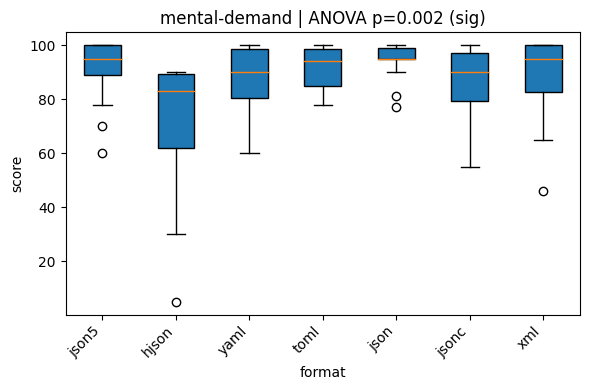

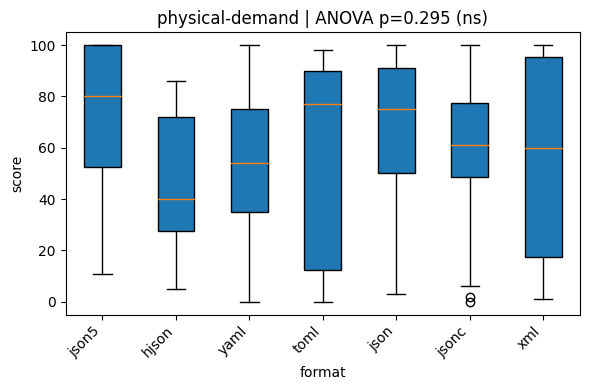

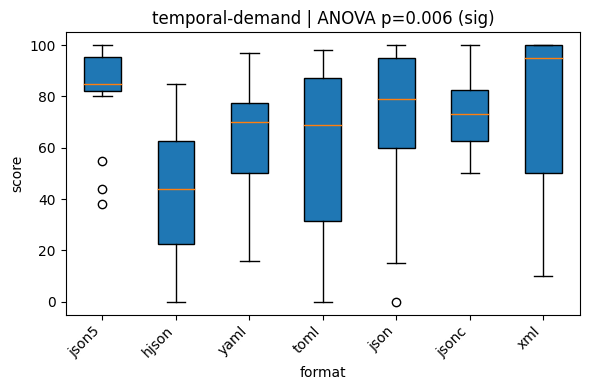

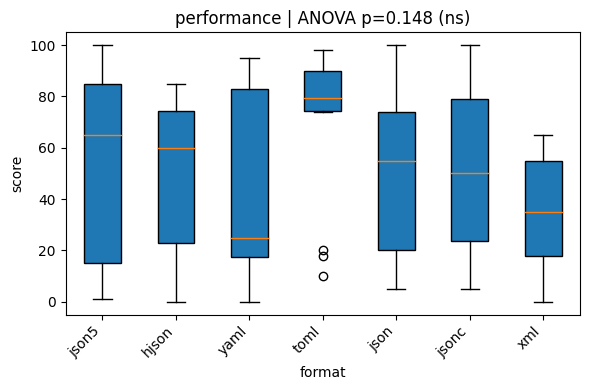

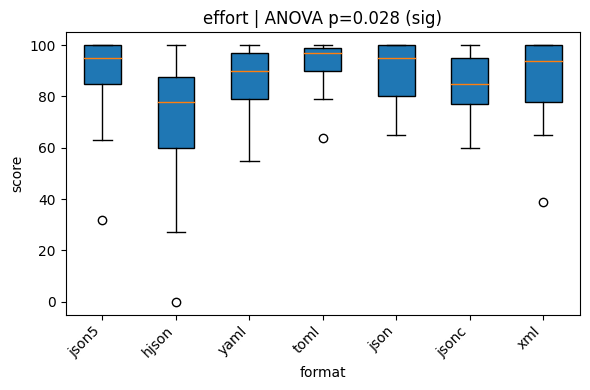

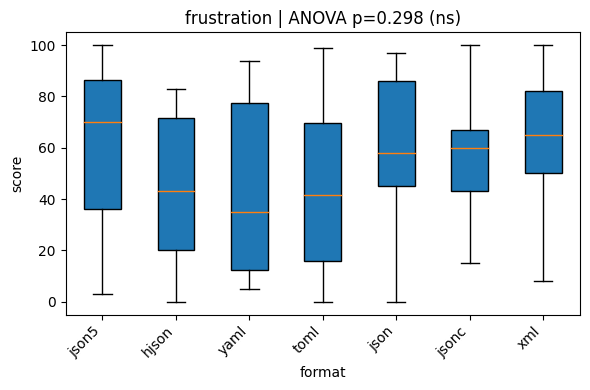

,task,homogeneity_p,test,test_p,significant,posthoc
0,mental-demand,0.151255,ANOVA,0.002115,True,"[hjson vs json, hjson vs json5, hjson vs toml,..."
1,physical-demand,0.659072,ANOVA,0.295161,False,[]
2,temporal-demand,0.238568,ANOVA,0.005873,True,"[hjson vs json, hjson vs json5, hjson vs jsonc]"
3,performance,0.495525,ANOVA,0.147673,False,[]
4,effort,0.230990,ANOVA,0.027573,True,"[hjson vs json, hjson vs toml]"
5,frustration,0.492372,ANOVA,0.297890,False,[]


In [32]:
df_nasa_tidy['score'] = pd.to_numeric(df_nasa_tidy['score'], errors='coerce')
summary_quiz_nasa = analyze_metric_by_base_task(
    df            = df_nasa_tidy,
    task_col      = 'task',
    format_col    = 'format',
    metric_col    = 'score',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_nasa

## post task question analysis

In [33]:

def clean_task_format(
    df: pd.DataFrame,
    task_col: str = 'task',
    format_col: str = 'format',
    new_col: str = None
) -> pd.DataFrame:
    """
    去掉 task_col 中紧跟在前缀后、尾部数字前的 '-<format>'。

    e.g. reading-task-tabular-json5-1 -> reading-task-tabular-1
    """
    df2 = df.copy()
    if new_col is None:
        new_col = task_col

    def _strip_fmt(row):
        t = str(row[task_col])
        fmt = re.escape(str(row[format_col]))
        # 匹配 -<fmt> 紧跟在后面并且前面后面都有 '-' 的那段
        return re.sub(fr"-{fmt}(?=-\d+$)", "", t)

    df2[new_col] = df2.apply(_strip_fmt, axis=1)
    return df2


## show post task question result

In [34]:
from quiz_evaluator import extract_post_task_questions
import re
import pandas as pd

df_post = extract_post_task_questions(all_data)

df_post_clean = clean_task_format(
    df_post,
    task_col='task',
    format_col='format'
)
df_post_clean

,participantId,format,task,startTime,endTime,duration_sec,difficulty,confidence
0,64457bc906c125cebd4bf66b,json5,writing-task-NL,1746559656954,1746559665762,8.808,1,7
1,64457bc906c125cebd4bf66b,json5,reading-task-tabular-1,1746560035266,1746560041262,5.996,4,4
2,64457bc906c125cebd4bf66b,json5,reading-task-tabular-2,1746560114063,1746560124630,10.567,4,3
3,64457bc906c125cebd4bf66b,json5,reading-task-tabular-3,1746560149554,1746560157039,7.485,5,3
4,64457bc906c125cebd4bf66b,json5,reading-task-tabular-4,1746560183791,1746560189177,5.386,3,5
...,...,...,...,...,...,...,...,...
1161,6675c40cdc52b37294f0514e,hjson,writing-task-tabular-hjson,1746235258159,1746235267565,9.406,5,4
1162,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-1,1746235543504,1746235551355,7.851,2,6
1163,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-2,1746235644408,1746235649351,4.943,2,6
1164,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-3,1746235723188,1746235729374,6.186,7,1


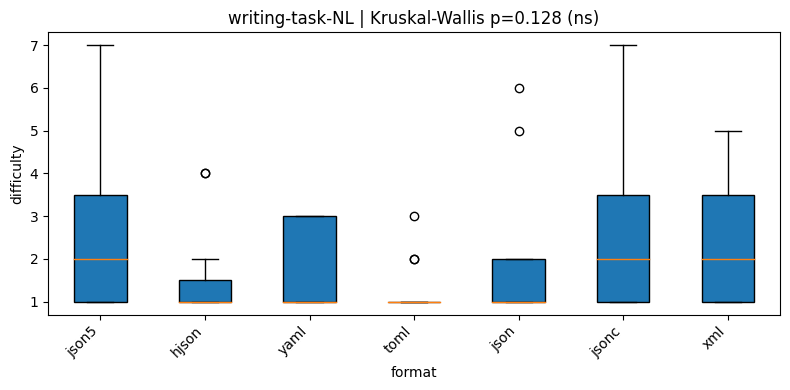

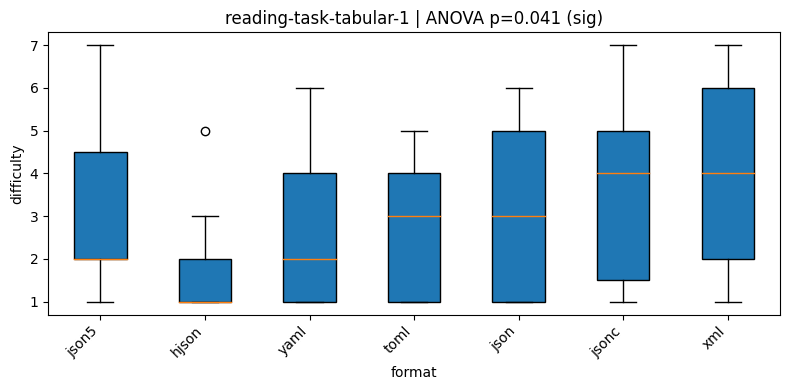

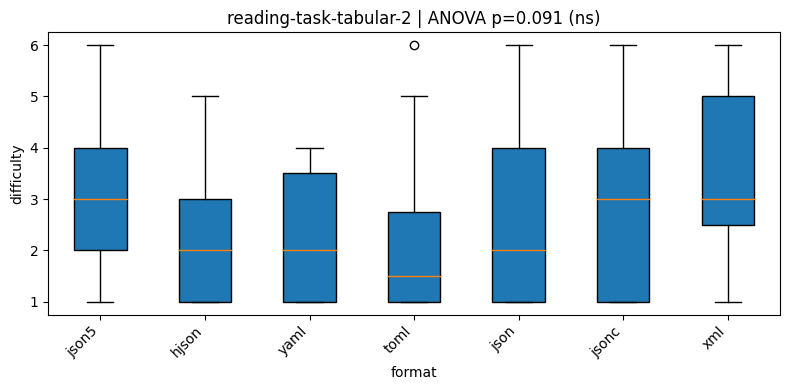

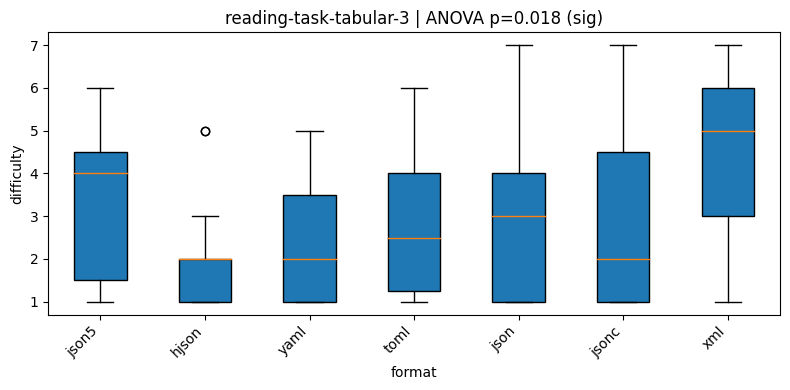

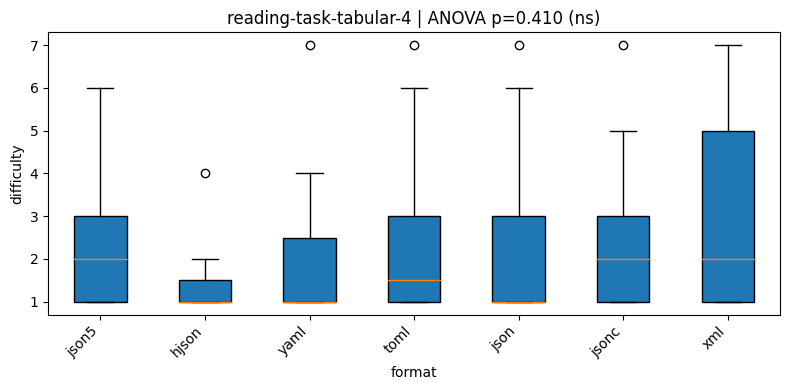

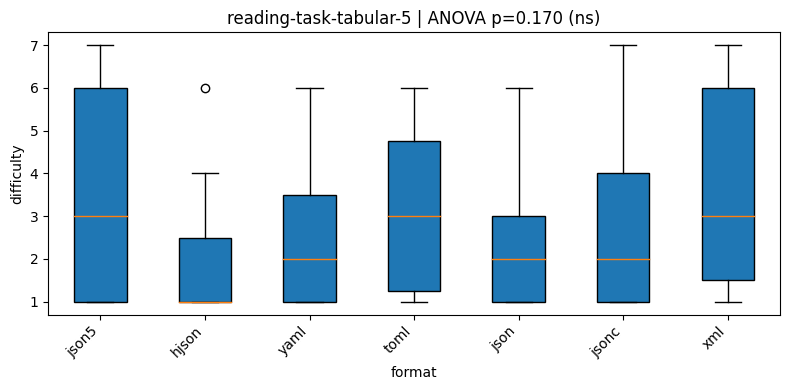

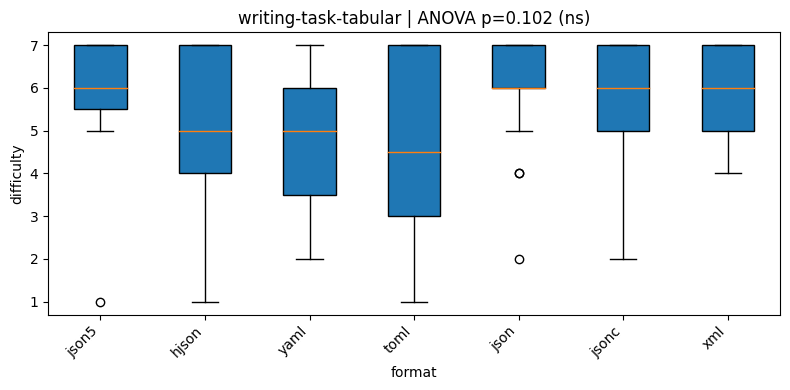

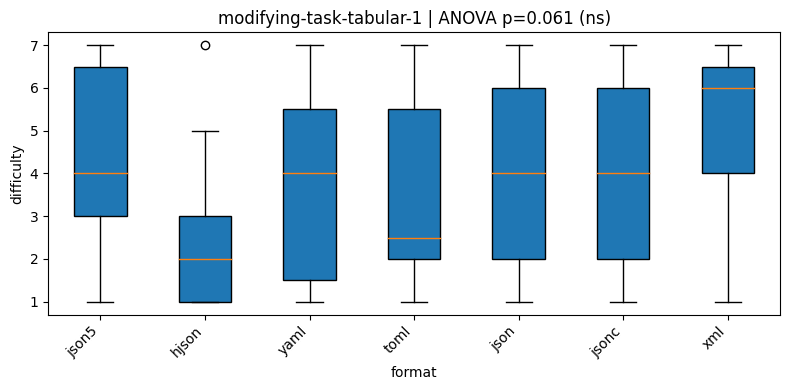

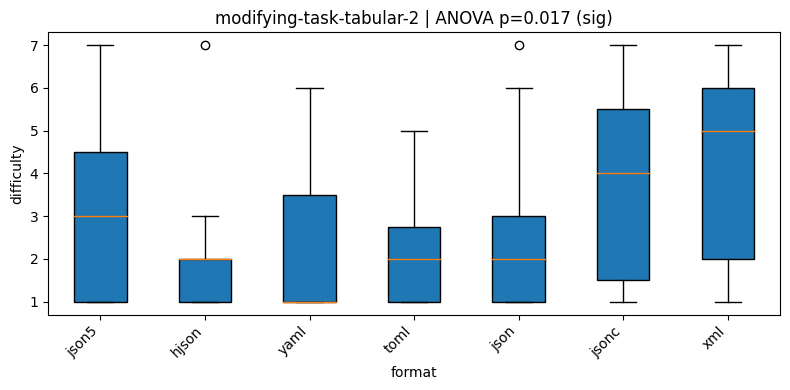

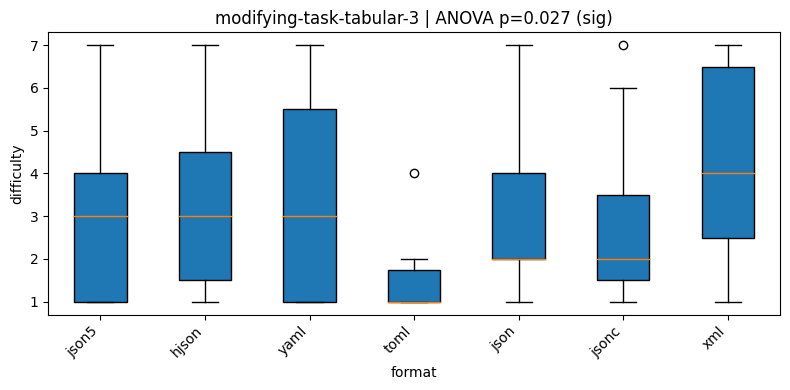

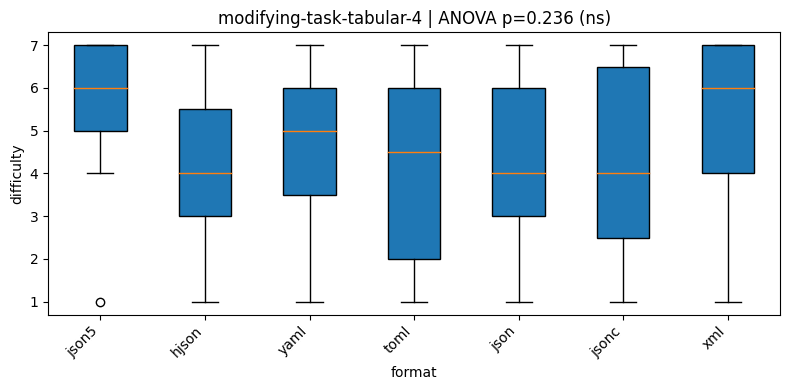

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-NL,0.043270,Kruskal-Wallis,0.128408,False,[]
1,reading-task-tabular-1,0.073300,ANOVA,0.041082,True,[hjson vs xml]
2,reading-task-tabular-2,0.475601,ANOVA,0.091000,False,[]
3,reading-task-tabular-3,0.337408,ANOVA,0.018268,True,"[hjson vs xml, xml vs yaml]"
4,reading-task-tabular-4,0.260737,ANOVA,0.409702,False,[]
5,reading-task-tabular-5,0.054295,ANOVA,0.169552,False,[]
6,writing-task-tabular,0.130812,ANOVA,0.101691,False,[]
7,modifying-task-tabular-1,0.720784,ANOVA,0.061420,False,[]
8,modifying-task-tabular-2,0.186398,ANOVA,0.016799,True,[]
9,modifying-task-tabular-3,0.056521,ANOVA,0.026805,True,[toml vs xml]


In [35]:
summary_post_d = analyze_metric_differences(
    df=df_post_clean,
    task_col='task',
    group_col='format',
    metric_col='difficulty',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_post_d

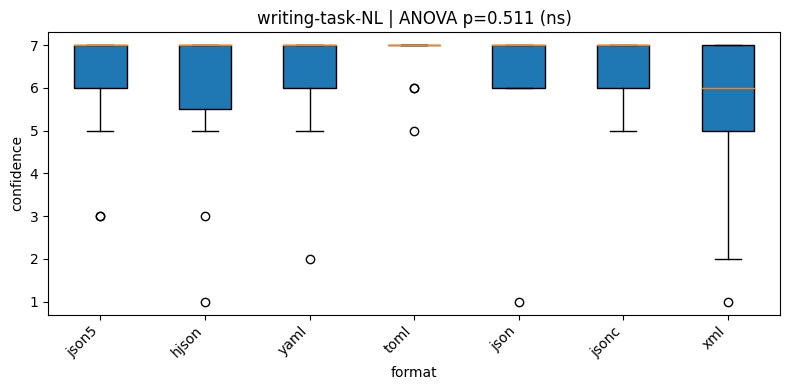

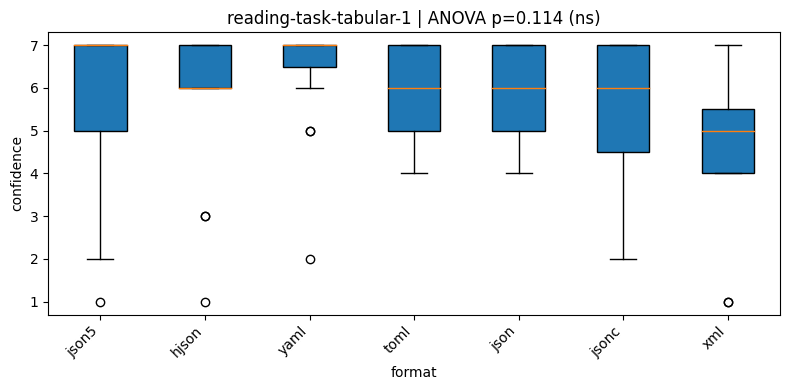

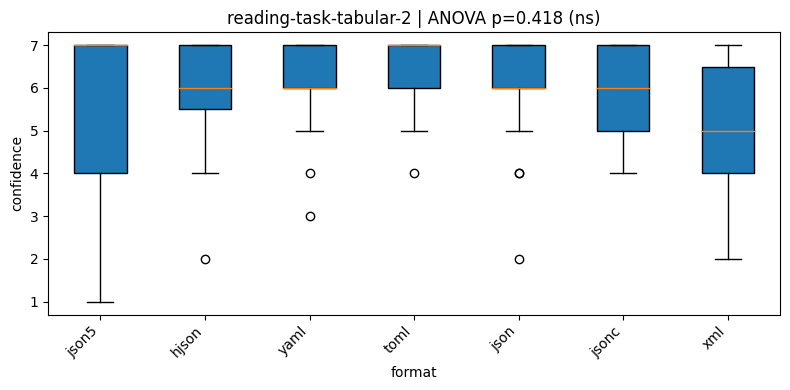

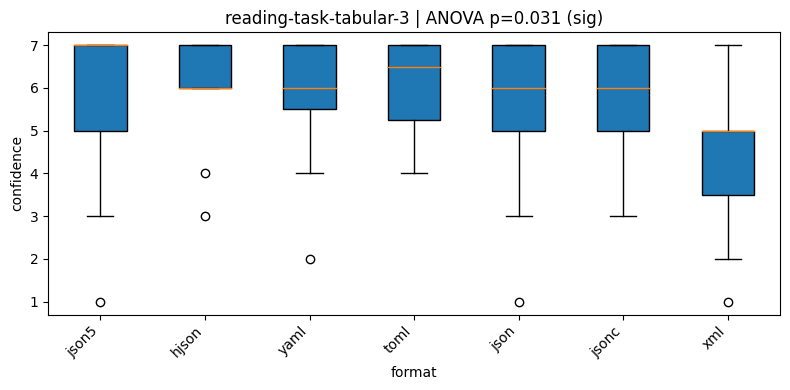

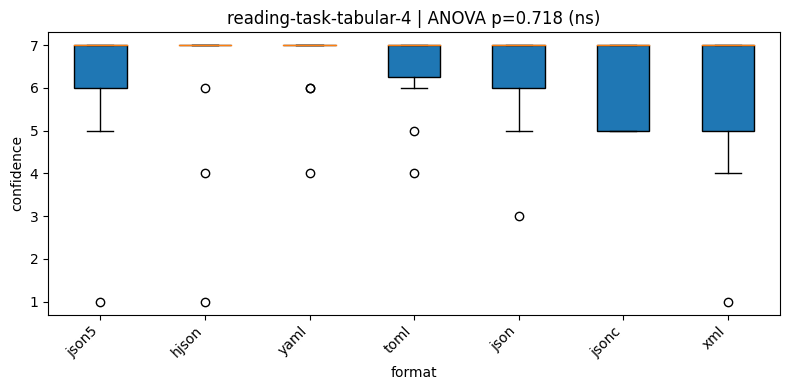

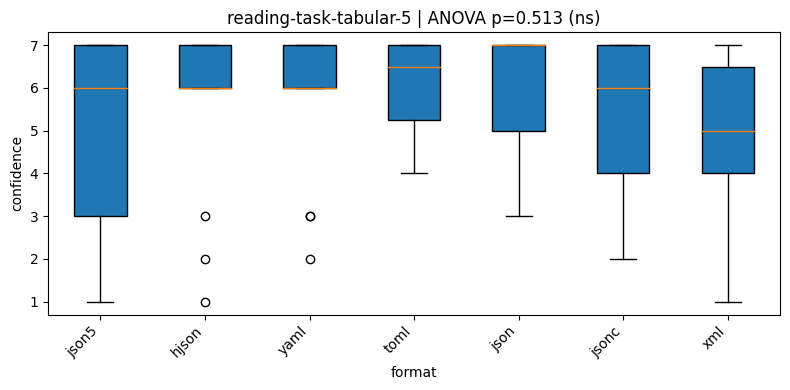

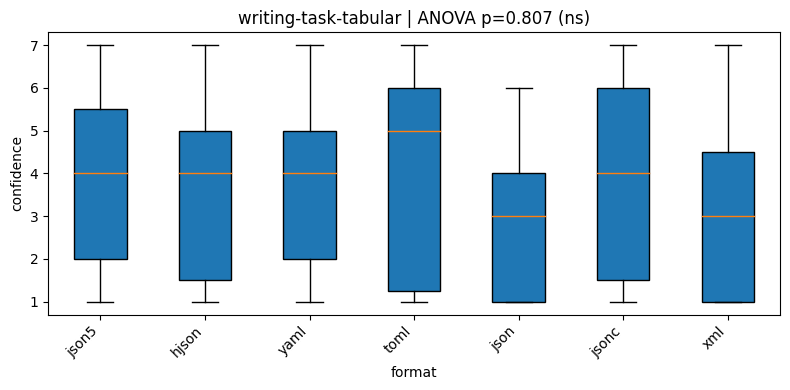

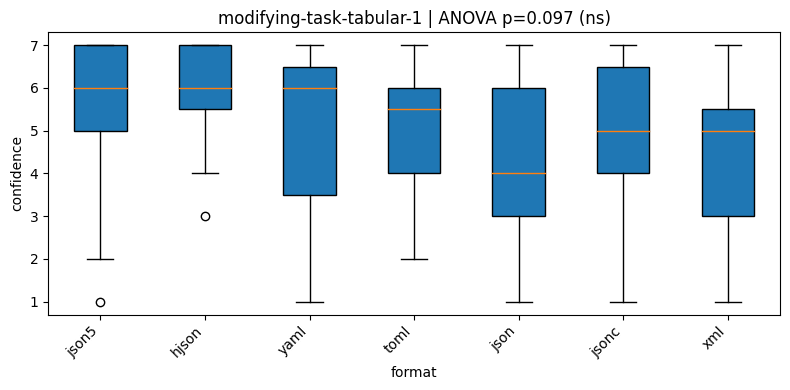

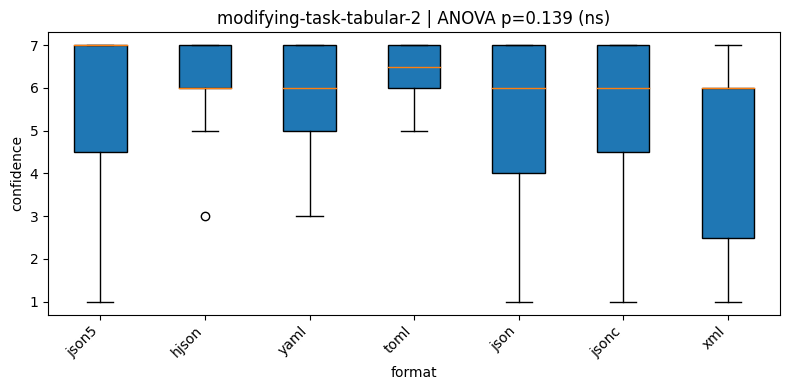

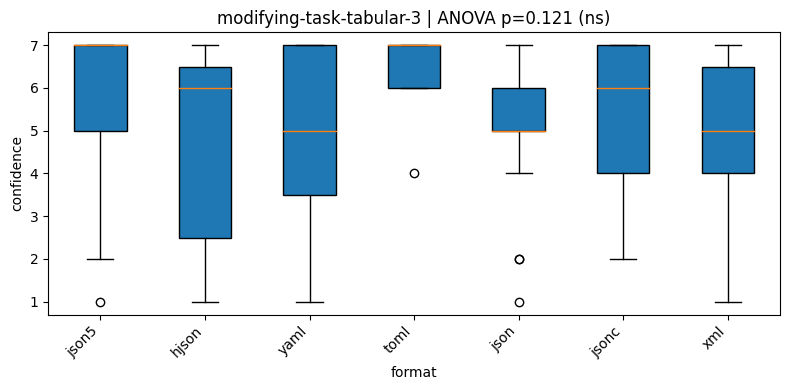

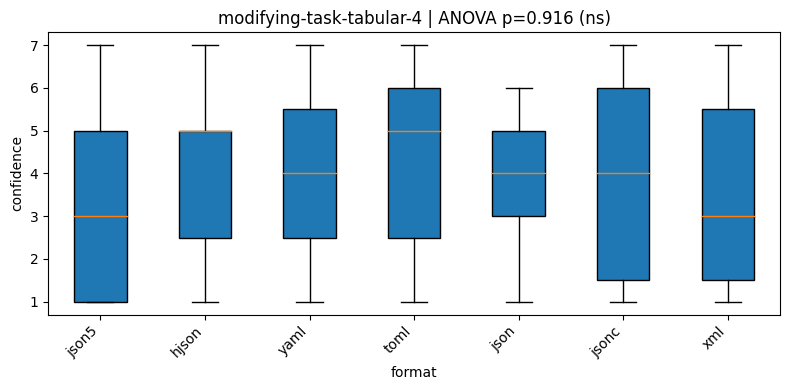

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-NL,0.501931,ANOVA,0.511296,False,[]
1,reading-task-tabular-1,0.771346,ANOVA,0.113917,False,[]
2,reading-task-tabular-2,0.431789,ANOVA,0.418484,False,[]
3,reading-task-tabular-3,0.871909,ANOVA,0.031149,True,"[hjson vs xml, toml vs xml]"
4,reading-task-tabular-4,0.718155,ANOVA,0.718155,False,[]
5,reading-task-tabular-5,0.676954,ANOVA,0.513058,False,[]
6,writing-task-tabular,0.862755,ANOVA,0.807411,False,[]
7,modifying-task-tabular-1,0.750518,ANOVA,0.096819,False,[]
8,modifying-task-tabular-2,0.273966,ANOVA,0.139046,False,[]
9,modifying-task-tabular-3,0.269199,ANOVA,0.121364,False,[]


In [36]:
summary_post_c = analyze_metric_differences(
    df=df_post_clean,
    task_col='task',
    group_col='format',
    metric_col='confidence',
    alpha=0.05,
    clean_suffix=True  
)

summary_post_c

## compare correctness/timing AND correctness/difficulty for single task (reading/post task question data)

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf


def compare_correctness_timing(
    df: pd.DataFrame,
    correct_col: str = 'correct',
    time_cols:   list = ['duration_sec'],
    alpha:       float = 0.05,
    figsize:     tuple = (6,4)
) -> pd.DataFrame:
    """
    比较 correctness (0/1) 与多个时长指标的关系，
    并给出易读的检验结果和解读，同时在箱线图标题里
    直接标出各项统计量（p 值和显著性标记）。

    返回值：每行一个 time_col，对应：
      - median_wrong / median_correct
      - U_stat, p_mwu
      - r_pb, p_corr
      - logit_coef, p_logit
      - interpretation（文字解读）
    """
    results = []

    # 1) 保证 correct 列是 0/1
    df2 = df.copy()
    df2[correct_col] = (
        pd.to_numeric(df2[correct_col], errors='coerce')
          .fillna(0)
          .astype(int)
    )

    for metric in time_cols:
        sub = df2[[correct_col, metric]].dropna()
        grp0 = sub.loc[sub[correct_col]==0, metric]
        grp1 = sub.loc[sub[correct_col]==1, metric]

        # 2) 中位数 & Mann–Whitney U
        med0, med1 = grp0.median(), grp1.median()
        direction = 'lower' if med1 < med0 else 'higher'

        if len(grp0) > 0 and len(grp1) > 0:
            U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
            sig_mwu = p_mwu < alpha
        else:
            U, p_mwu, sig_mwu = None, None, False

        # 3) 点二列相关
        try:
            r_pb, p_corr = pointbiserialr(sub[correct_col], sub[metric])
            sig_corr = p_corr < alpha
        except:
            r_pb, p_corr, sig_corr = None, None, False

        # 4) Logistic 回归
        try:
            logit = smf.logit(f"{correct_col} ~ {metric}", data=sub).fit(disp=False)
            coef   = logit.params.get(metric, None)
            p_log  = logit.pvalues.get(metric, None)
            sig_log = (p_log is not None and p_log < alpha)
        except:
            coef, p_log, sig_log = None, None, False

        # 5) 画箱线图，并把所有 p 值和 ★/ns 都贴到标题里
        plt.figure(figsize=figsize)
        sns.boxplot(x=correct_col, y=metric, data=sub, palette='pastel')
        title = (
            f"{metric} by {correct_col}\n"
            f"MW p={p_mwu:.3f} ({'★' if sig_mwu else 'ns'});  "
            f"pb r={r_pb:.3f} (p={p_corr:.3f});  "
            f"logit coef={coef:.3e} (p={p_log:.3f})"
        )
        plt.title(title)
        plt.xlabel(correct_col)
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()

        # 6) 文字解读
        interp = (
            f"Median(time|correct=1) is {direction} than wrong "
            f"({med1:.2f} vs {med0:.2f}). "
            f"Mann–Whitney U={U:.1f}, p={p_mwu:.3f} "
            f"({'sig' if sig_mwu else 'ns'}); "
            f"Point‐biserial r={r_pb:.3f}, p={p_corr:.3f} "
            f"({'sig' if sig_corr else 'ns'}); "
            f"Logit coef={coef:.3e}, p={p_log:.3f} "
            f"({'sig' if sig_log else 'ns'})."
        )

        results.append({
            'metric':         metric,
            'median_wrong':   med0,
            'median_correct': med1,
            'U_stat':         U,
            'p_mwu':          p_mwu,
            'r_pb':           r_pb,
            'p_corr':         p_corr,
            'logit_coef':     coef,
            'p_logit':        p_log,
            'interpretation': interp
        })

    return pd.DataFrame(results)


def compare_correctness_timing_by_format(
    df: pd.DataFrame,
    correct_col: str   = 'correct',
    time_cols:   list  = ['duration_sec'],
    format_col:  str   = 'format',
    alpha:       float = 0.05,
    figsize:     tuple = (12, 4)
):
    """
    按 format 做 FacetGrid：
      - 每个 format 一列
      - 箱线图展示 correct=0/1 在 time_cols 上的分布
    并且在每个 Facet 上标出 Mann–Whitney p 值。

    参数
    ----
    df          原始 df，需要有 correct_col, time_cols, format_col
    correct_col 0/1 列
    time_cols   要比较的时长列列表
    format_col  按哪个列分面
    alpha       显著性水平，用来判断 p<alpha
    figsize     (宽,高)，这里高为 Facet 高度

    返回
    ----
    None （直接画图并在标题里标 p 值）
    """
    # 确保 correct 是 0/1
    df = df.copy()
    df[correct_col] = pd.to_numeric(df[correct_col], errors='coerce').fillna(0).astype(int)

    for metric in time_cols:
        # FacetGrid: 每个 format 一列
        formats = df[format_col].unique()
        ncol = len(formats)
        fig, axes = plt.subplots(1, ncol, figsize=(figsize[0], figsize[1]), sharey=True)
        if ncol == 1:
            axes = [axes]

        for ax, fmt in zip(axes, formats):
            sub = df[df[format_col] == fmt]
            sns.boxplot(x=correct_col, y=metric, data=sub, ax=ax, palette='pastel')
            ax.set_title(f"{fmt}")
            ax.set_xlabel("correct")
            ax.set_ylabel(metric if ax is axes[0] else "")
            # 统计检验
            grp0 = sub.loc[sub[correct_col]==0, metric]
            grp1 = sub.loc[sub[correct_col]==1, metric]
            if len(grp0)>0 and len(grp1)>0:
                _, p = mannwhitneyu(grp0, grp1, alternative='two-sided')
                sig = "★" if p<alpha else "ns"
                ax.text(0.5, 0.95, f"p={p:.3f} ({sig})",
                        transform=ax.transAxes,
                        ha='center', va='top',
                        fontsize=10)
        plt.suptitle(f"{metric} by correct, split by {format_col}", y=1.02)
        plt.tight_layout()
        plt.show()

def compare_posttask_correctness(
    df_post:     pd.DataFrame,
    df_correct:  pd.DataFrame,
    tasks:       list,
    metric_col:  str = 'difficulty',
    correct_col: str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    task_col:        str = 'task',
    alpha:       float = 0.05,
    figsize:     tuple = (6,4)
) -> pd.DataFrame:
    """
    对 post-task 的 difficulty/confidence 与 correctness(0/1) 做对比，
    只保留 task_col 中包含 tasks 列表的行，然后
    1) 箱线图，标题一次性展示 MW U、point-biserial 和 logit 的 p 值及显著★/ns  
    2) 返回汇总表：median_wrong/median_correct + 各检验的统计量 + interpretation
    """
    # —— 1. 过滤 & 合并 correct ——
    pat = "|".join(tasks)
    df_sel = df_post[df_post[task_col].str.contains(pat)].copy()

    dfm = pd.merge(
        df_sel,
        df_correct[[participant_col, format_col, task_col, correct_col]],
        on=[participant_col, format_col, task_col],
        how='inner'
    ).dropna(subset=[metric_col, correct_col])
    dfm[correct_col] = dfm[correct_col].astype(int)

    sub = dfm[[metric_col, correct_col]]

    # —— 2. 分组中位数 & Mann–Whitney U —— 
    grp0 = sub.loc[sub[correct_col]==0, metric_col]
    grp1 = sub.loc[sub[correct_col]==1, metric_col]
    med0, med1 = grp0.median(), grp1.median()
    direction = 'lower' if med1 < med0 else 'higher'

    if len(grp0)>0 and len(grp1)>0:
        U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
        sig_mwu = p_mwu < alpha
    else:
        U, p_mwu, sig_mwu = None, None, False

    # —— 3. 点二列相关 —— 
    try:
        r_pb, p_corr = pointbiserialr(sub[correct_col], sub[metric_col])
        sig_corr = p_corr < alpha
    except:
        r_pb, p_corr, sig_corr = None, None, False

    # —— 4. Logistic 回归 —— 
    try:
        logit = smf.logit(f"{correct_col} ~ {metric_col}", data=sub).fit(disp=False)
        coef   = logit.params.get(metric_col, None)
        p_log  = logit.pvalues.get(metric_col, None)
        sig_log = (p_log is not None and p_log < alpha)
    except:
        coef, p_log, sig_log = None, None, False

    # —— 5. 画箱线图 + 在标题一次性标三项检验 —— 
    plt.figure(figsize=figsize)
    sns.boxplot(x=correct_col, y=metric_col, data=sub, palette='pastel')
    title = (
        f"{metric_col} by correct\n"
        f"MW p={p_mwu:.3f} ({'★' if sig_mwu else 'ns'});  "
        f"pb r={r_pb:.3f} (p={p_corr:.3f});  "
        f"logit coef={coef:.3e} (p={p_log:.3f})"
    )
    plt.title(title)
    plt.xlabel('correct (0=wrong,1=right)')
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

    # —— 6. 文字解读 & 返回表 —— 
    interp = (
        f"median({metric_col}|correct=1) is {direction} than wrong "
        f"({med1:.2f} vs {med0:.2f}). "
        f"MW U={U:.1f}, p={p_mwu:.3f} ({'sig' if sig_mwu else 'ns'}); "
        f"point-biserial r={r_pb:.3f}, p={p_corr:.3f} "
        f"({'sig' if sig_corr else 'ns'}); "
        f"logit coef={coef:.3e}, p={p_log:.3f} "
        f"({'sig' if sig_log else 'ns'})."
    )

    return pd.DataFrame([{
        'metric':         metric_col,
        'median_wrong':   med0,
        'median_correct': med1,
        'U_stat':         U,
        'p_mwu':          p_mwu,
        'r_pb':           r_pb,
        'p_corr':         p_corr,
        'logit_coef':     coef,
        'p_logit':        p_log,
        'interpretation': interp
    }])


def compare_posttask_by_format(
    df_post:     pd.DataFrame,
    df_correct:  pd.DataFrame,
    tasks:       list,
    metric_col:  str = 'difficulty',
    correct_col: str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    task_col:        str = 'task',
    alpha:       float = 0.05,
    figsize:     tuple = (12,4)
):
    """
    对 post-task 的 metric_col vs correct 做 Facet 分面：
      - 只保留 task_col 中包含 tasks 列表的行
      - 每个 format 一子图，箱线展示 correct=0/1 的分布
      - 在子图顶部标出 Mann–Whitney p 值（★ 表示 p<alpha）
    """
    # 1) 过滤 tasks
    pat = "|".join(tasks)
    df_sel = df_post[df_post[task_col].str.contains(pat)].copy()

    # 2) 合并 correct
    dfm = pd.merge(
        df_sel,
        df_correct[[participant_col, format_col, task_col, correct_col]],
        on=[participant_col, format_col, task_col],
        how='inner'
    ).dropna(subset=[metric_col, correct_col])
    dfm[correct_col] = dfm[correct_col].astype(int)

    # 3) 准备分面
    formats = dfm[format_col].unique()
    ncol = len(formats)
    fig, axes = plt.subplots(1, ncol, figsize=(figsize[0], figsize[1]), sharey=True)
    if ncol == 1:
        axes = [axes]

    # 4) 每个 format 画箱线并注 p 值
    for ax, fmt in zip(axes, formats):
        sub = dfm[dfm[format_col] == fmt]
        sns.boxplot(x=correct_col, y=metric_col, data=sub, ax=ax, palette='pastel')
        ax.set_title(fmt)
        ax.set_xlabel('correct')
        ax.set_ylabel(metric_col if ax is axes[0] else '')

        # Mann–Whitney
        g0 = sub.loc[sub[correct_col]==0, metric_col]
        g1 = sub.loc[sub[correct_col]==1, metric_col]
        if len(g0)>0 and len(g1)>0:
            _, p = mannwhitneyu(g0, g1, alternative='two-sided')
            sig = '★' if p<alpha else 'ns'
            ax.text(0.5, 0.95, f"p={p:.3f} ({sig})",
                    transform=ax.transAxes,
                    ha='center', va='top',
                    fontsize=10)
    plt.suptitle(f"{metric_col} by correctness for tasks {tasks}", y=1.02)
    plt.tight_layout()
    plt.show()

def filter_tasks_by_prefix(
    df: pd.DataFrame,
    prefixes,
    task_col: str = 'task'
) -> pd.DataFrame:
    """
    提取 df 中 task_col 列以某些前缀开头的所有行。

    参数
    ----
    df : pd.DataFrame
      原始表格。
    prefixes : str 或 list/tuple of str
      单个前缀，或一组前缀。例如 'reading-task-tabular'，或 ['reading-task-tabular','modifying-task']。
    task_col : str
      存储任务名称的列名，默认 'task'。

    返回
    ----
    pd.DataFrame
      只保留那些 task_col 值以任一前缀开头的行（并 reset_index）。
    """
    # 确保 prefixes 是可迭代的字符串列表
    if isinstance(prefixes, str):
        prefixes = [prefixes]
    prefixes = tuple(prefixes)

    mask = df[task_col].str.startswith(prefixes)
    return df[mask].reset_index(drop=True)

## plot result

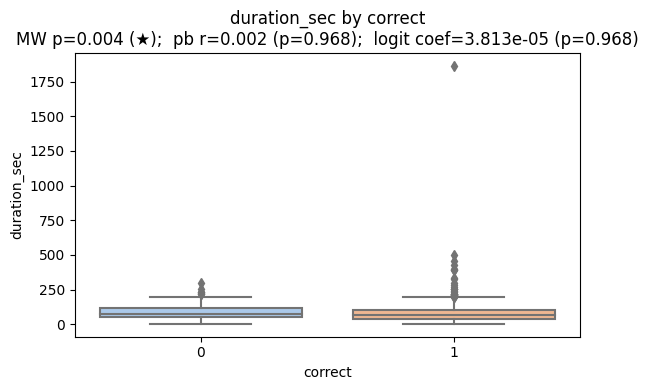

Median(time|correct=1) is lower than wrong (62.92 vs 74.01). Mann–Whitney U=33908.0, p=0.004 (sig); Point‐biserial r=0.002, p=0.968 (ns); Logit coef=3.813e-05, p=0.968 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,74.007,62.918,33908.0,0.004049,0.001763,0.967705,0.000038,0.967632,Median(time|correct=1) is lower than wrong (62...


In [51]:
summary = compare_correctness_timing(
    df_reading_result,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

for txt in summary['interpretation']:
    print(txt)
    
summary

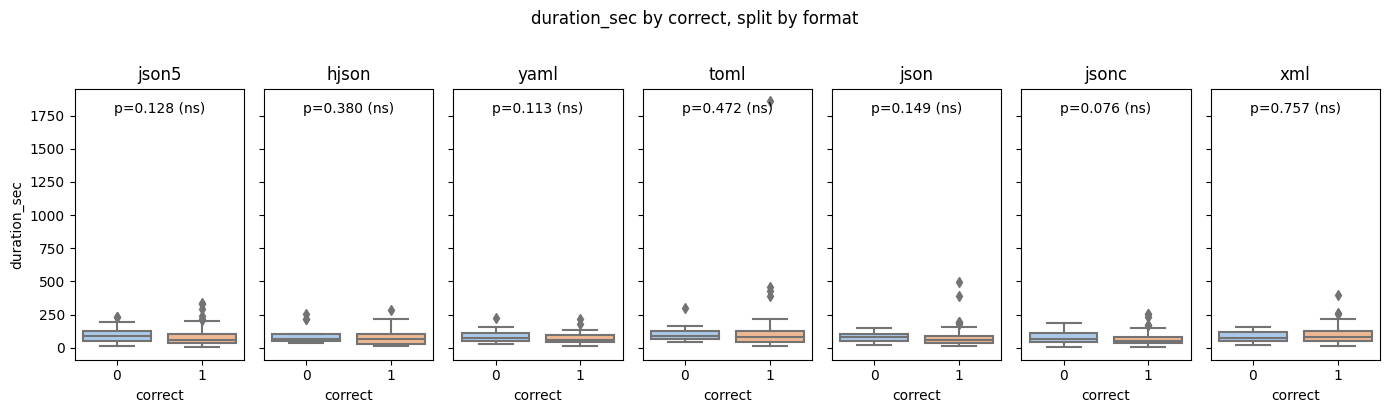

In [52]:
compare_correctness_timing_by_format(
    df          = df_reading_result,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

In [ ]:
## TO-DO: CHECK DIFFERENT TASK AND OVERALL TASK - TIME/CORRECTNESS

In [60]:
df_reading_agg

,participantId,task,format,response,start_time,end_time,duration_sec,help_count,correct_answer,correct
0,64457bc906c125cebd4bf66b,reading-task-tabular-1,json5,9,1.746560e+12,1.746560e+12,14.824,0,87,0.0
1,64457bc906c125cebd4bf66b,reading-task-tabular-2,json5,quiz2,1.746560e+12,1.746560e+12,72.466,0,quiz2,1.0
2,64457bc906c125cebd4bf66b,reading-task-tabular-3,json5,4,1.746560e+12,1.746560e+12,24.606,0,4,1.0
3,64457bc906c125cebd4bf66b,reading-task-tabular-4,json5,Bob,1.746560e+12,1.746560e+12,26.410,0,Bob,1.0
4,64457bc906c125cebd4bf66b,reading-task-tabular-5,json5,[Eve],1.746560e+12,1.746560e+12,96.426,0,"[Bob, Eve], [Alice]",0.0
...,...,...,...,...,...,...,...,...,...,...
631,67f1a4f8dd44e7cd5adffa29,reading-task-tabular,json5,NaN,NaN,NaN,1056.874,0,NaN,1.0
632,67f1c7bd6f1c4a3d8deae02f,reading-task-tabular,toml,NaN,NaN,NaN,577.437,0,NaN,0.8
633,67f3619e16d4ca195fbd1bd0,reading-task-tabular,yaml,NaN,NaN,NaN,603.879,0,NaN,0.6
634,67f5bb69760b211cdfe8021c,reading-task-tabular,jsonc,NaN,NaN,NaN,173.583,0,NaN,0.8


In [61]:
df_reading_result_1=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-1']
df_reading_result_2=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-2']
df_reading_result_3=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-3']
df_reading_result_4=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-4']
df_reading_result_5=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-5']
df_reading_result_all=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular']

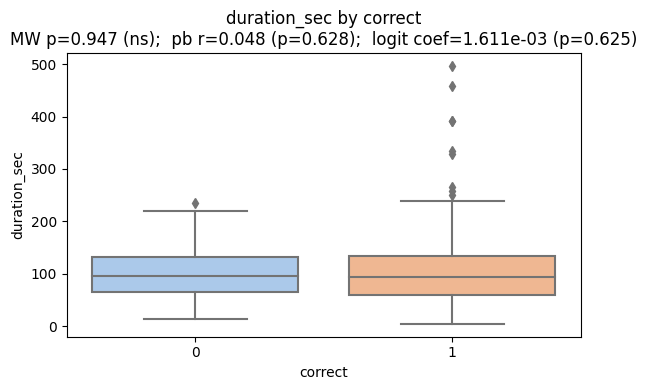

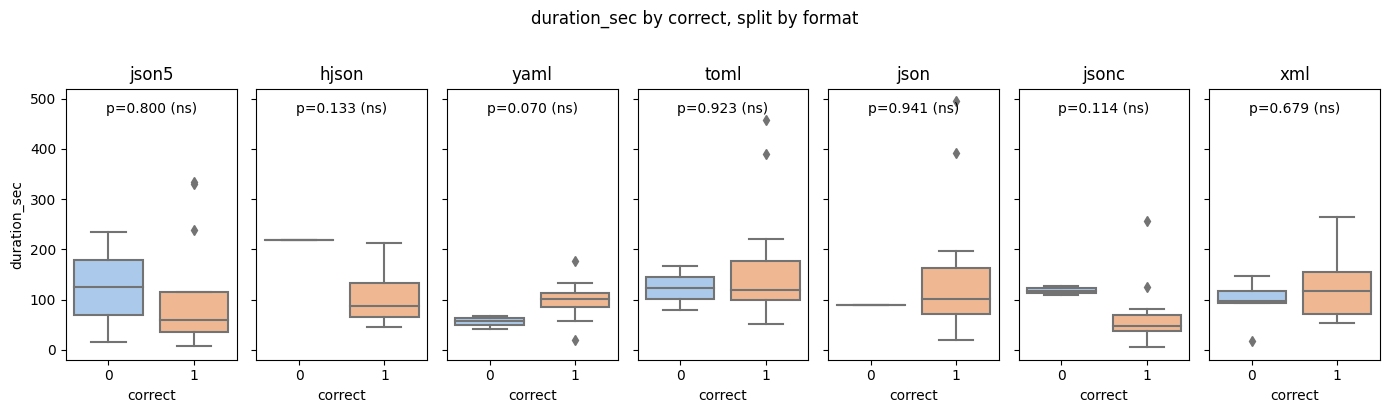

Median(time|correct=1) is lower than wrong (93.80 vs 95.23). Mann–Whitney U=728.0, p=0.947 (ns); Point‐biserial r=0.048, p=0.628 (ns); Logit coef=1.611e-03, p=0.625 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,95.232,93.8,728.0,0.947228,0.047615,0.627901,0.001611,0.625272,Median(time|correct=1) is lower than wrong (93...


In [62]:
summary_1 = compare_correctness_timing(
    df_reading_result_1,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_1,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_1['interpretation']:
    print(txt)
    
summary_1

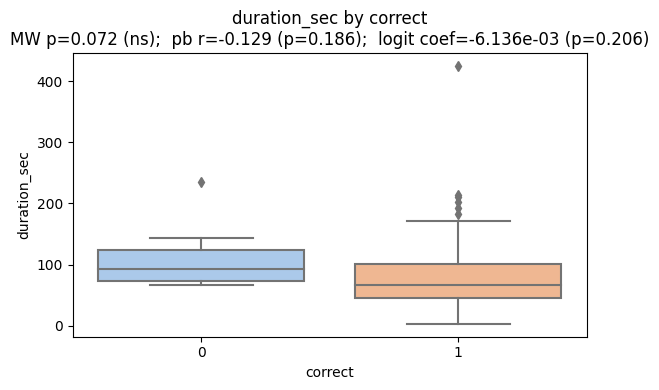

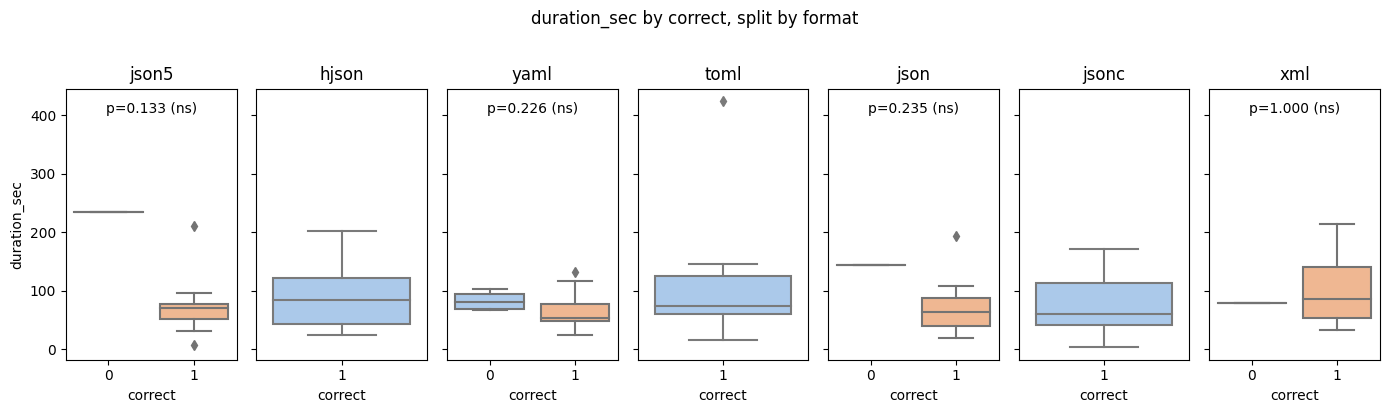

Median(time|correct=1) is lower than wrong (67.07 vs 91.99). Mann–Whitney U=488.0, p=0.072 (ns); Point‐biserial r=-0.129, p=0.186 (ns); Logit coef=-6.136e-03, p=0.206 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,91.988,67.067,488.0,0.072401,-0.129338,0.186372,-0.006136,0.205988,Median(time|correct=1) is lower than wrong (67...


In [68]:
summary_2 = compare_correctness_timing(
    df_reading_result_2,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_2,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_2['interpretation']:
    print(txt)
    
summary_2

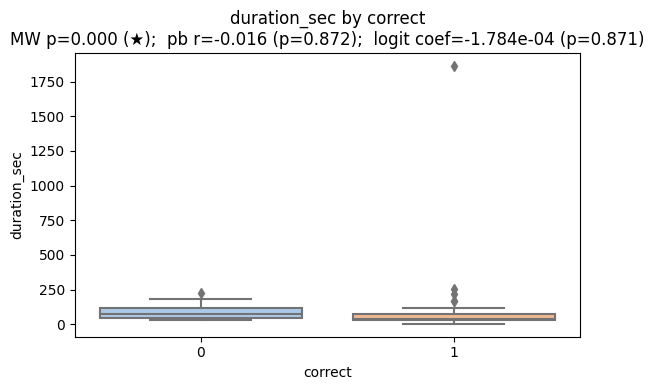

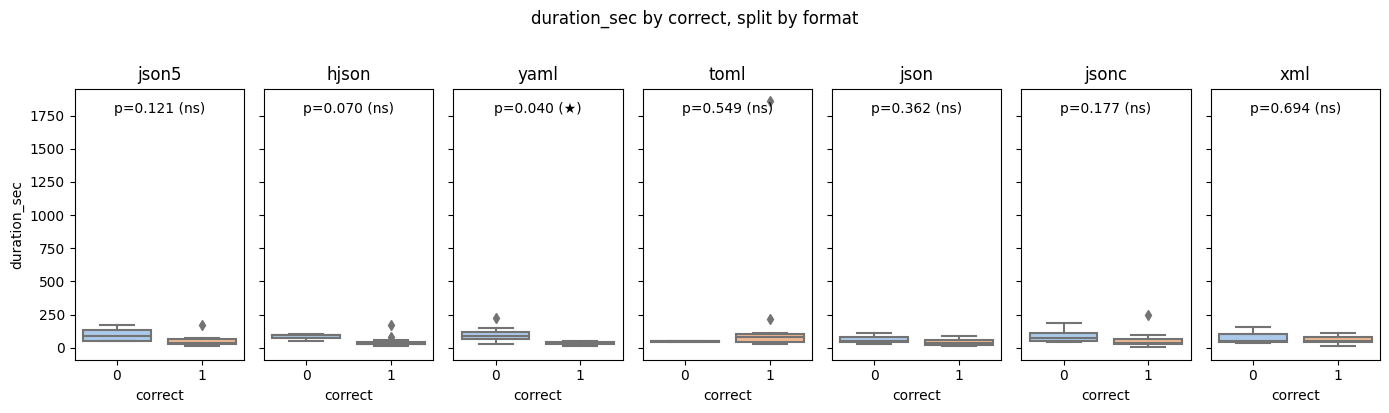

Median(time|correct=1) is lower than wrong (37.99 vs 72.51). Mann–Whitney U=1788.0, p=0.000 (sig); Point‐biserial r=-0.016, p=0.872 (ns); Logit coef=-1.784e-04, p=0.871 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,72.506,37.992,1788.0,0.000251,-0.015799,0.872295,-0.000178,0.871271,Median(time|correct=1) is lower than wrong (37...


In [67]:
summary_3 = compare_correctness_timing(
    df_reading_result_3,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_3,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_3['interpretation']:
    print(txt)
    
summary_3

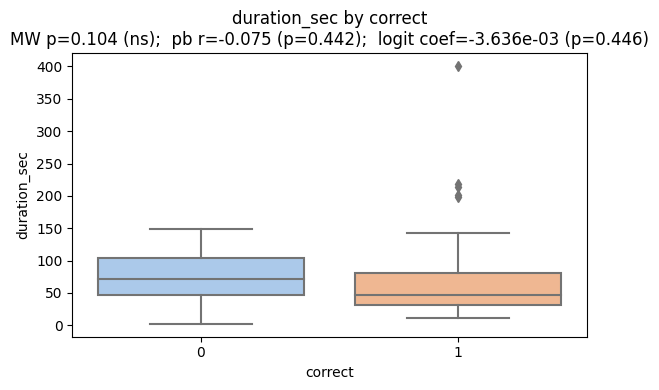

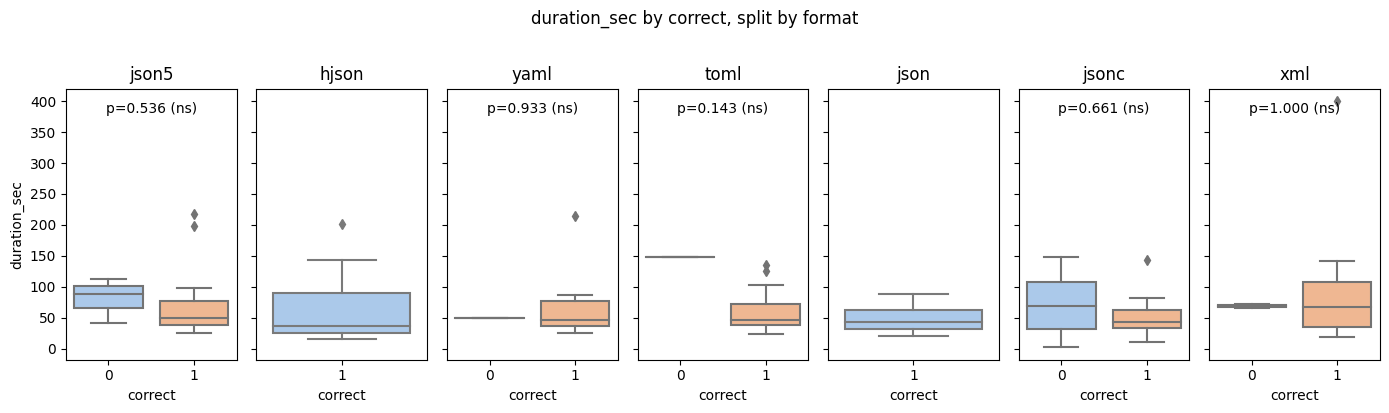

Median(time|correct=1) is lower than wrong (46.88 vs 71.70). Mann–Whitney U=680.0, p=0.104 (ns); Point‐biserial r=-0.075, p=0.442 (ns); Logit coef=-3.636e-03, p=0.446 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,71.696,46.881,680.0,0.103854,-0.075394,0.442417,-0.003636,0.446106,Median(time|correct=1) is lower than wrong (46...


In [66]:
summary_4 = compare_correctness_timing(
    df_reading_result_4,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_4,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_4['interpretation']:
    print(txt)
    
summary_4

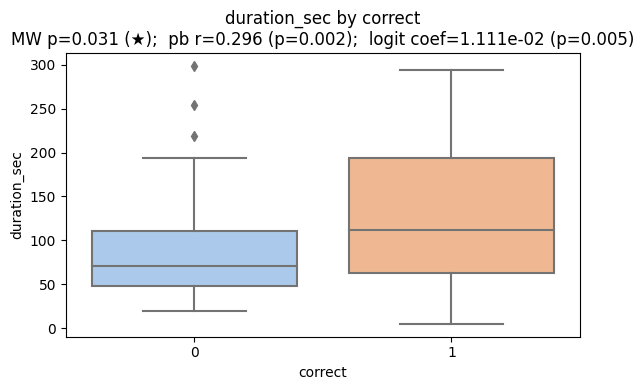

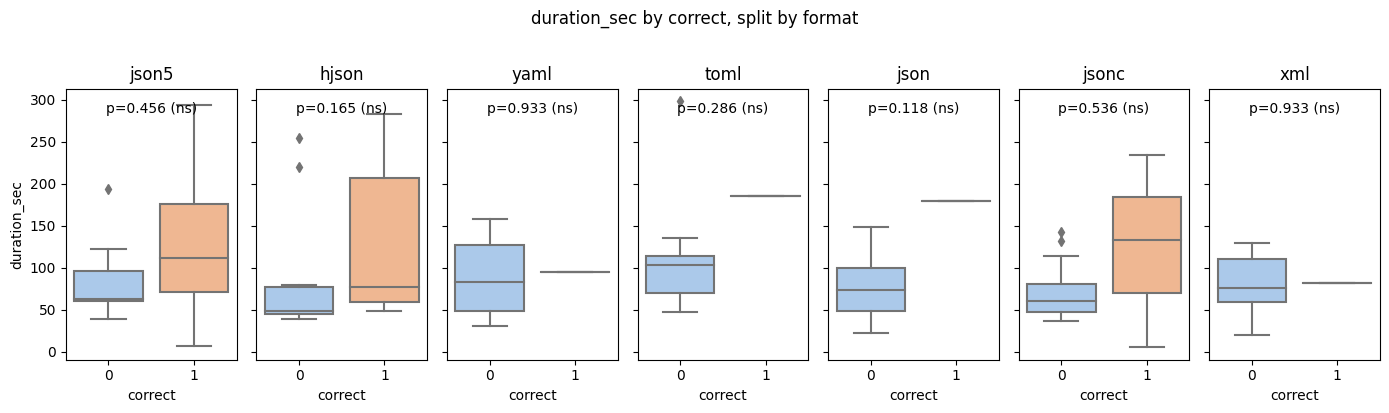

Median(time|correct=1) is higher than wrong (111.45 vs 70.56). Mann–Whitney U=535.0, p=0.031 (sig); Point‐biserial r=0.296, p=0.002 (sig); Logit coef=1.111e-02, p=0.005 (sig).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,70.564,111.446,535.0,0.030906,0.295748,0.002084,0.011112,0.005324,Median(time|correct=1) is higher than wrong (1...


In [65]:
summary_5 = compare_correctness_timing(
    df_reading_result_5,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_5,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_5['interpretation']:
    print(txt)
    
summary_5

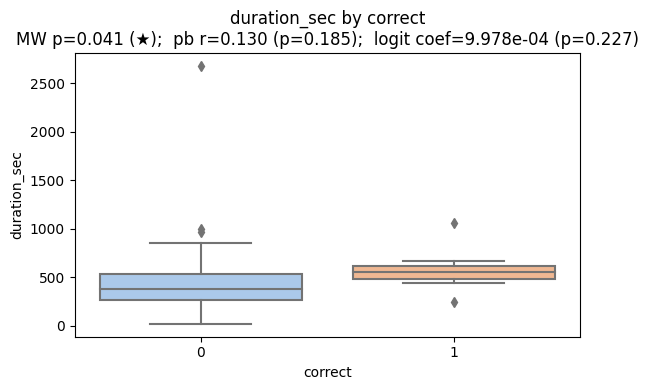

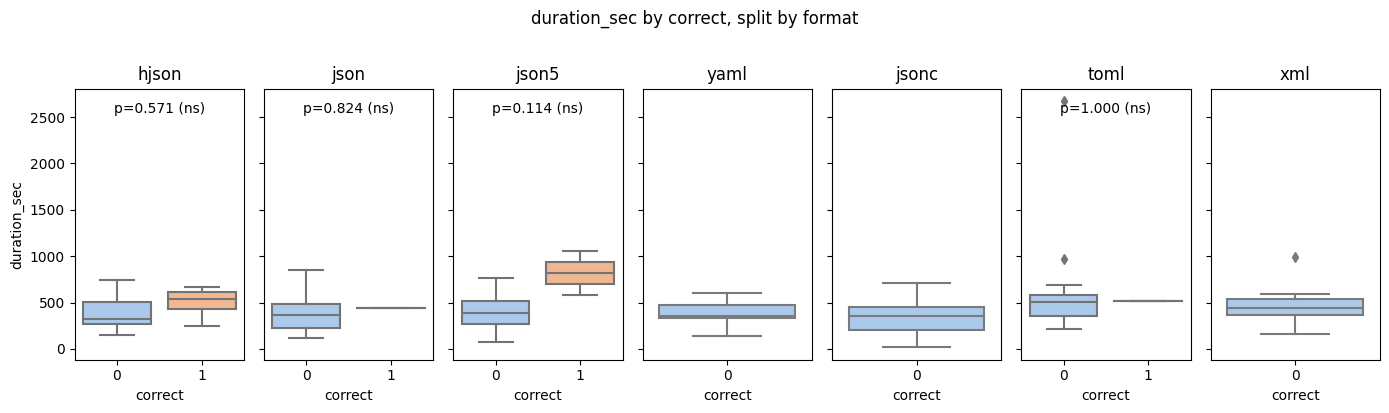

Median(time|correct=1) is higher than wrong (547.63 vs 375.56). Mann–Whitney U=222.0, p=0.041 (sig); Point‐biserial r=0.130, p=0.185 (ns); Logit coef=9.978e-04, p=0.227 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,375.5635,547.629,222.0,0.041062,0.129869,0.184556,0.000998,0.227323,Median(time|correct=1) is higher than wrong (5...


In [64]:
summary_all = compare_correctness_timing(
    df_reading_result_all,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)

compare_correctness_timing_by_format(
    df          = df_reading_result_all,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

for txt in summary_all['interpretation']:
    print(txt)
    
summary_all

In [77]:
import numpy as np
import pandas as pd

def append_task_prefix_summary(
    df: pd.DataFrame,
    prefix: str,
    metric_cols: list = ['difficulty', 'confidence'],
    id_cols:     list = ['participantId', 'format'],
    task_col:    str  = 'task'
) -> pd.DataFrame:
    """
    在原 df 不变的前提下：
      1. 过滤出所有 task 以 prefix 开头的行；
      2. 按 id_cols 聚合 metric_cols 的平均值，生成一条 summary 行（task=prefix）；
      3. 其余列补 NaN；
      4. 把 summary 行 append 回原始 df 并返回。

    参数：
      df          原始 DataFrame
      prefix      要聚合的 task 前缀（如 'reading-task-tabular'）
      metric_cols 要聚合的数值列列表
      id_cols     分组保留列列表（通常 ['participantId','format']）
      task_col    存放任务名称的列名
    """
    # 1) 过滤
    mask = df[task_col].str.startswith(prefix)
    df_sub = df[mask].copy()

    # 如果没有任何匹配，直接返回原 df
    if df_sub.empty:
        return df.copy()

    # 2) 聚合计算均值
    agg = (
        df_sub
        .groupby(id_cols, as_index=False)
        .agg({col: 'mean' for col in metric_cols})
    )
    # 3) 生成 summary 行
    agg[task_col] = prefix
    # 4) 补齐其余列
    for col in df.columns:
        if col not in agg.columns:
            agg[col] = np.nan
    agg = agg[df.columns]  # 保持列顺序

    # 5) 合并并返回
    return pd.concat([df, agg], ignore_index=True)

prefix = 'reading-task-tabular'
pattern = re.compile(rf'^{re.escape(prefix)}')
df_post_reading = df_post_clean[df_post_clean['task'].str.match(pattern)].copy()

post_reading = append_task_prefix_summary(
    df_post_reading,
    prefix='reading-task-tabular',
    metric_cols=['difficulty','confidence'],
    id_cols=['participantId','format'],
    task_col='task'
)

post_reading



,participantId,format,task,startTime,endTime,duration_sec,difficulty,confidence
0,64457bc906c125cebd4bf66b,json5,reading-task-tabular-1,1.746560e+12,1.746560e+12,5.996,4.0,4.0
1,64457bc906c125cebd4bf66b,json5,reading-task-tabular-2,1.746560e+12,1.746560e+12,10.567,4.0,3.0
2,64457bc906c125cebd4bf66b,json5,reading-task-tabular-3,1.746560e+12,1.746560e+12,7.485,5.0,3.0
3,64457bc906c125cebd4bf66b,json5,reading-task-tabular-4,1.746560e+12,1.746560e+12,5.386,3.0,5.0
4,64457bc906c125cebd4bf66b,json5,reading-task-tabular-5,1.746560e+12,1.746560e+12,7.962,6.0,2.0
...,...,...,...,...,...,...,...,...
631,67f1a4f8dd44e7cd5adffa29,json5,reading-task-tabular,NaN,NaN,NaN,5.4,6.4
632,67f1c7bd6f1c4a3d8deae02f,toml,reading-task-tabular,NaN,NaN,NaN,1.6,7.0
633,67f3619e16d4ca195fbd1bd0,yaml,reading-task-tabular,NaN,NaN,NaN,2.4,7.0
634,67f5bb69760b211cdfe8021c,jsonc,reading-task-tabular,NaN,NaN,NaN,3.6,5.4


In [74]:
# df_reading_agg

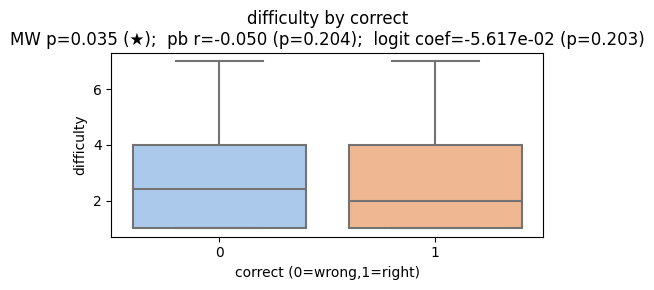

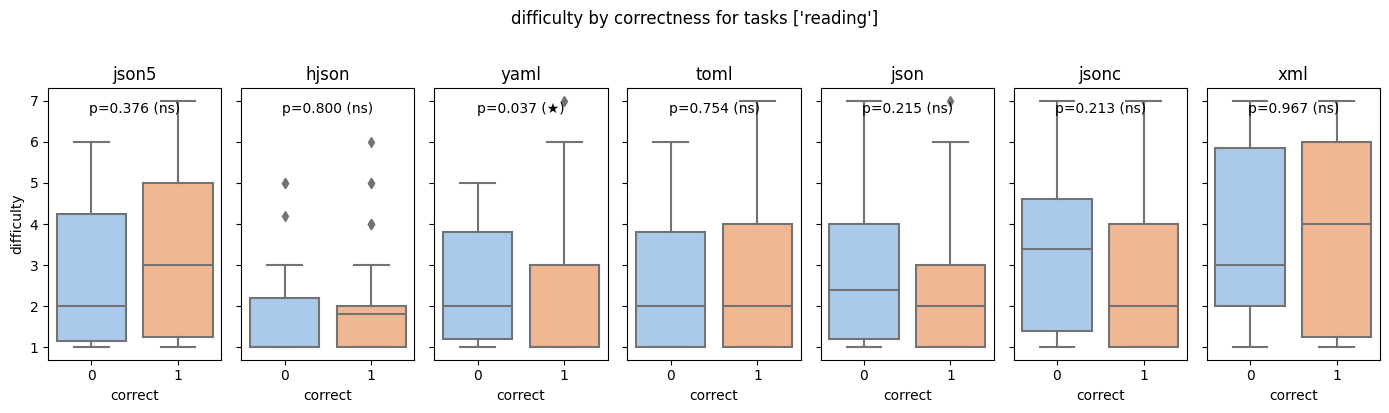

median(difficulty|correct=1) is lower than wrong (2.00 vs 2.40). MW U=53249.0, p=0.035 (sig); point-biserial r=-0.050, p=0.204 (ns); logit coef=-5.617e-02, p=0.203 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,2.4,2.0,53249.0,0.035342,-0.050485,0.203558,-0.056168,0.203425,median(difficulty|correct=1) is lower than wro...


In [82]:
# 假设 df_post_clean, df_reading_clean（或 df_quiz_clean） 已就绪
summary_d_c = compare_posttask_correctness(
    df_post     = post_reading,
    df_correct  = df_reading_agg,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading,
    df_correct = df_reading_agg,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c['interpretation']:
    print(txt)

summary_d_c



In [85]:
post_reading_1=post_reading[post_reading['task'] == 'reading-task-tabular-1']
df_reading_agg_1=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-1']
post_reading_2=post_reading[post_reading['task'] == 'reading-task-tabular-2']
df_reading_agg_2=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-2']
post_reading_3=post_reading[post_reading['task'] == 'reading-task-tabular-3']
df_reading_agg_3=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-3']
post_reading_4=post_reading[post_reading['task'] == 'reading-task-tabular-4']
df_reading_agg_4=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-4']
post_reading_5=post_reading[post_reading['task'] == 'reading-task-tabular-5']
df_reading_agg_5=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular-5']
post_reading_all=post_reading[post_reading['task'] == 'reading-task-tabular']
df_reading_agg_all=df_reading_agg[df_reading_agg['task'] == 'reading-task-tabular']

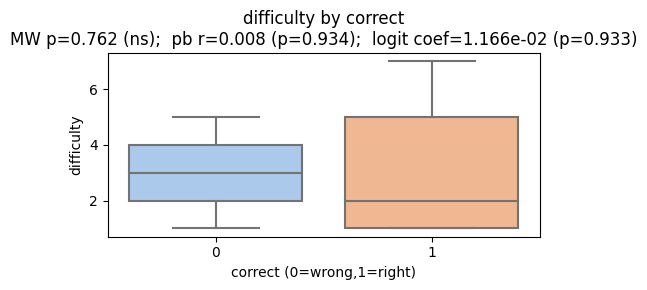

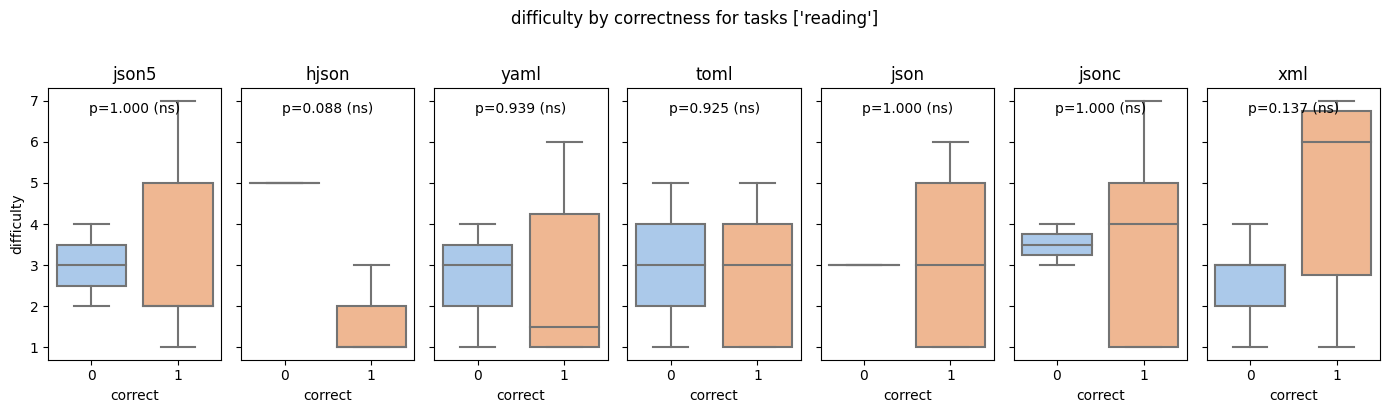

median(difficulty|correct=1) is lower than wrong (2.00 vs 3.00). MW U=754.0, p=0.762 (ns); point-biserial r=0.008, p=0.934 (ns); logit coef=1.166e-02, p=0.933 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,3.0,2.0,754.0,0.761778,0.008131,0.934069,0.011656,0.933284,median(difficulty|correct=1) is lower than wro...


In [86]:
summary_d_c_1 = compare_posttask_correctness(
    df_post     = post_reading_1,
    df_correct  = df_reading_agg_1,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_1,
    df_correct = df_reading_agg_1,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_1['interpretation']:
    print(txt)

summary_d_c_1

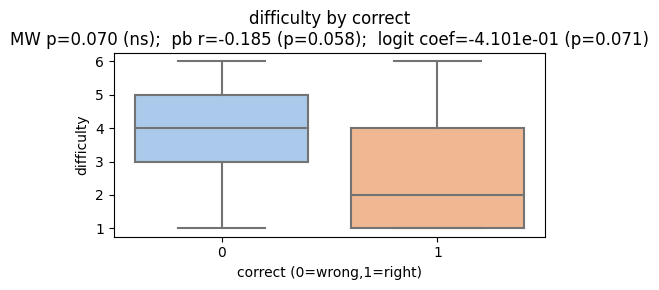

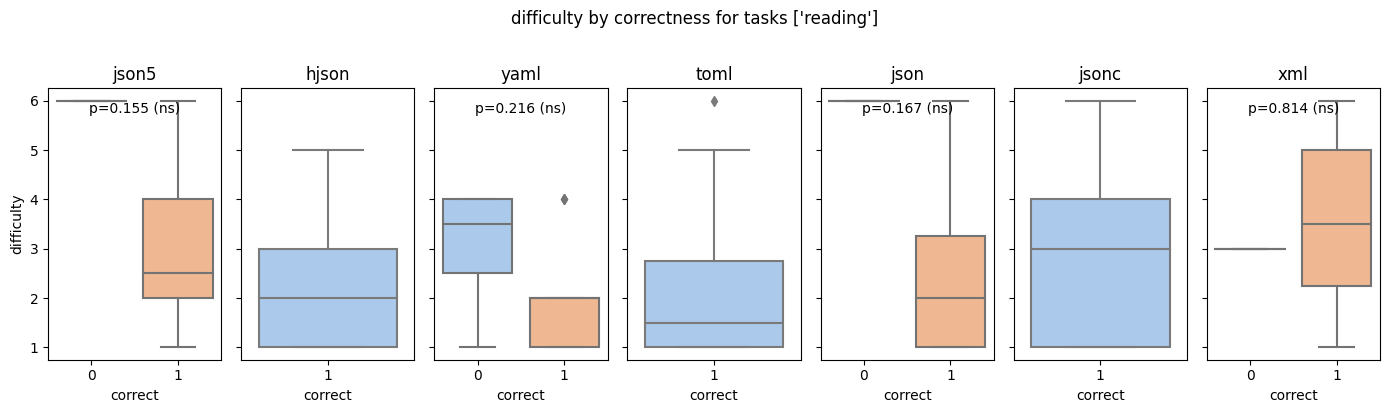

median(difficulty|correct=1) is lower than wrong (2.00 vs 4.00). MW U=485.5, p=0.070 (ns); point-biserial r=-0.185, p=0.058 (ns); logit coef=-4.101e-01, p=0.071 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,4.0,2.0,485.5,0.069911,-0.18495,0.057695,-0.410106,0.070862,median(difficulty|correct=1) is lower than wro...


In [87]:
summary_d_c_2 = compare_posttask_correctness(
    df_post     = post_reading_2,
    df_correct  = df_reading_agg_2,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_2,
    df_correct = df_reading_agg_2,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_2['interpretation']:
    print(txt)

summary_d_c_2

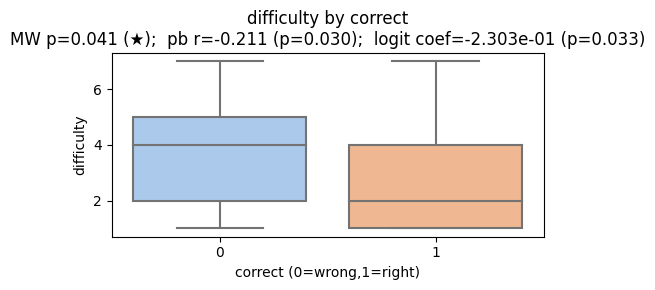

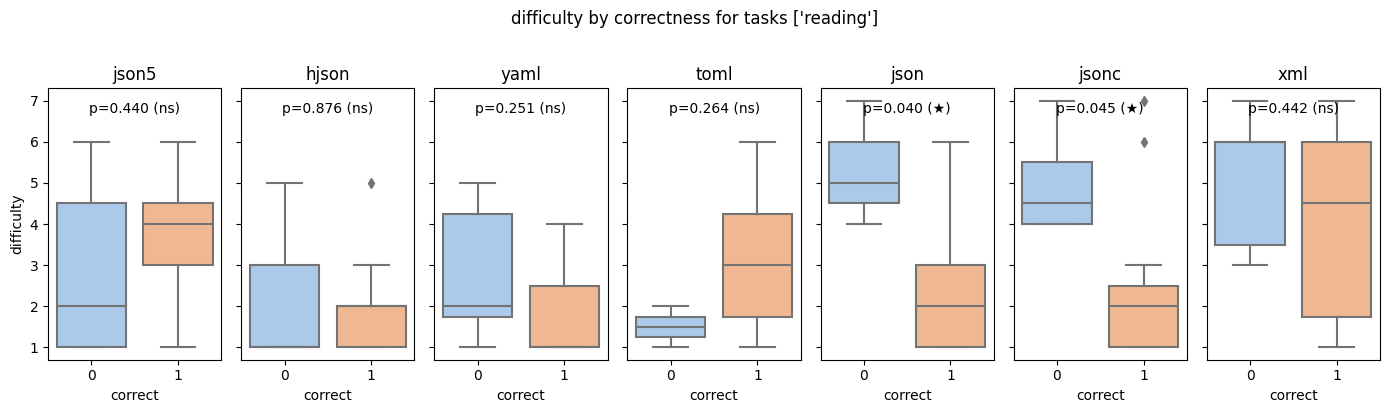

median(difficulty|correct=1) is lower than wrong (2.00 vs 4.00). MW U=1541.0, p=0.041 (sig); point-biserial r=-0.211, p=0.030 (sig); logit coef=-2.303e-01, p=0.033 (sig).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,4.0,2.0,1541.0,0.04055,-0.211109,0.029835,-0.230326,0.032574,median(difficulty|correct=1) is lower than wro...


In [91]:
summary_d_c_3 = compare_posttask_correctness(
    df_post     = post_reading_3,
    df_correct  = df_reading_agg_3,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_3,
    df_correct = df_reading_agg_3,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_3['interpretation']:
    print(txt)

summary_d_c_3

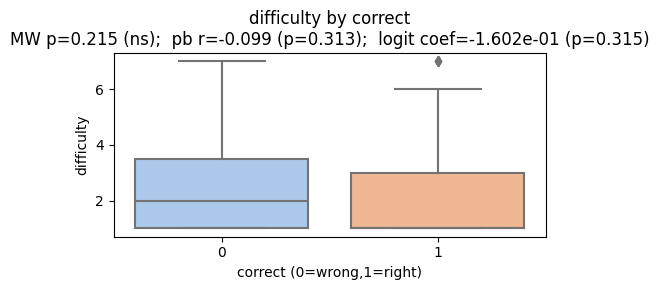

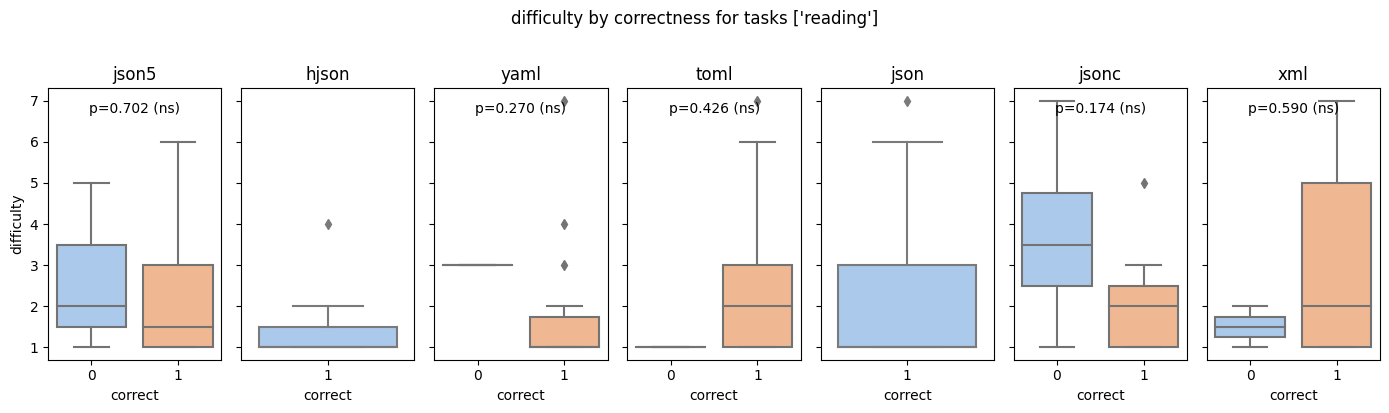

median(difficulty|correct=1) is lower than wrong (2.00 vs 3.00). MW U=754.0, p=0.762 (ns); point-biserial r=0.008, p=0.934 (ns); logit coef=1.166e-02, p=0.933 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,2.0,1.0,632.5,0.215348,-0.099013,0.312594,-0.160215,0.314929,median(difficulty|correct=1) is lower than wro...


In [90]:
summary_d_c_4 = compare_posttask_correctness(
    df_post     = post_reading_4,
    df_correct  = df_reading_agg_4,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_4,
    df_correct = df_reading_agg_4,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_1['interpretation']:
    print(txt)

summary_d_c_4

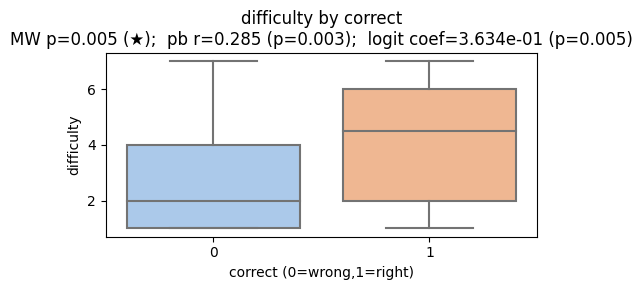

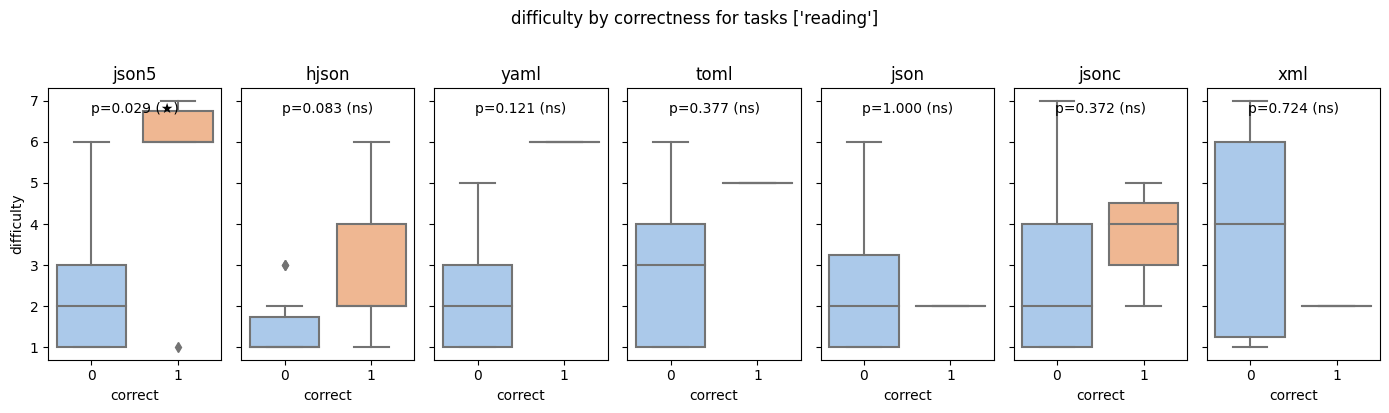

median(difficulty|correct=1) is lower than wrong (2.00 vs 3.00). MW U=754.0, p=0.762 (ns); point-biserial r=0.008, p=0.934 (ns); logit coef=1.166e-02, p=0.933 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,2.0,4.5,466.0,0.004768,0.284618,0.003107,0.363401,0.005374,median(difficulty|correct=1) is higher than wr...


In [89]:
summary_d_c_5 = compare_posttask_correctness(
    df_post     = post_reading_5,
    df_correct  = df_reading_agg_5,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_5,
    df_correct = df_reading_agg_5,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_1['interpretation']:
    print(txt)

summary_d_c_5

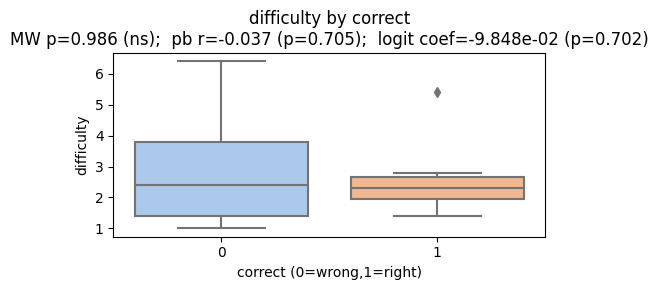

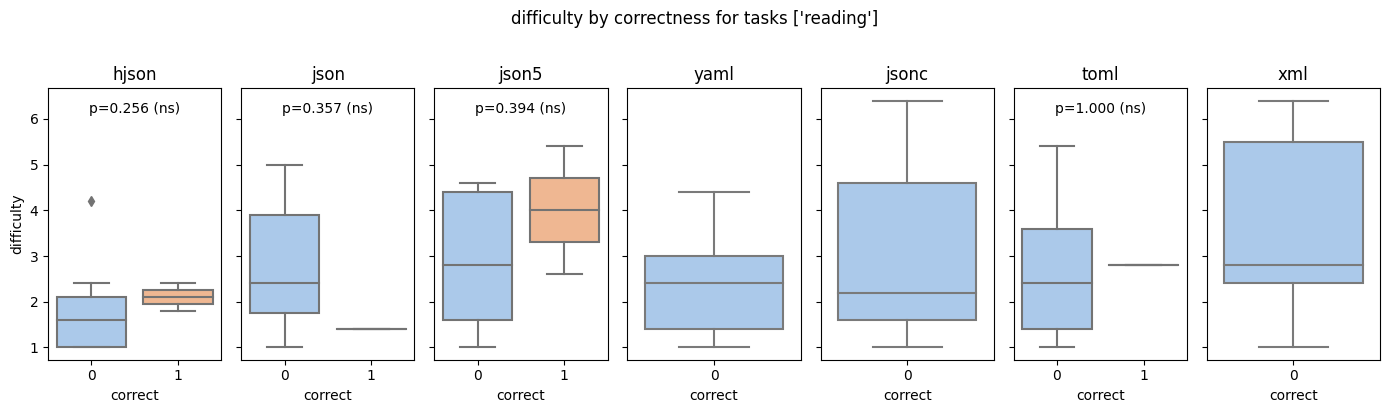

median(difficulty|correct=1) is lower than wrong (2.30 vs 2.40). MW U=394.0, p=0.986 (ns); point-biserial r=-0.037, p=0.705 (ns); logit coef=-9.848e-02, p=0.702 (ns).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,2.4,2.3,394.0,0.985653,-0.037191,0.705063,-0.098481,0.702412,median(difficulty|correct=1) is lower than wro...


In [88]:
summary_d_c_all = compare_posttask_correctness(
    df_post     = post_reading_all,
    df_correct  = df_reading_agg_all,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)

compare_posttask_by_format(
    df_post    = post_reading_all,
    df_correct = df_reading_agg_all,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

for txt in summary_d_c_all['interpretation']:
    print(txt)

summary_d_c_all

## compare overall correctness/mental effort

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

def analyze_metric_vs_correct(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    participant_col: str   = 'participantId',
    format_col:      str   = 'format',
    metric_col:      str   = 'mental-demand',
    correct_col:     str   = 'correct',
    merge_on:        list  = None,
    alpha:           float = 0.05,
    figsize:         tuple = (6,4)
) -> pd.DataFrame:
    """
    比较连续指标 metric_col 与正确率 correct_col 的关系：
     - Pearson, Spearman, OLS 三项检验
     - 绘制散点+回归线，并在标题写明 r/p/slope/p 和显著性 (★/ns)
     - 返回一行 DataFrame，包含各检验值及 'interpretation'
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 1) 合并与清洗
    df = (
        pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        )
        .dropna(subset=[metric_col, correct_col])
    )
    n = len(df)
    if n == 0:
        raise ValueError("合并后无数据，请检查 merge_on 或列名。")

    x = df[metric_col].astype(float)
    y = df[correct_col].astype(float)

    # 2) 三项统计检验
    try:
        r_p, p_p = pearsonr(x, y)
    except:
        r_p, p_p = None, None
    try:
        r_s, p_s = spearmanr(x, y)
    except:
        r_s, p_s = None, None
    try:
        fit = smf.ols(f"{correct_col} ~ {metric_col}", data=df).fit()
        slope  = fit.params.get(metric_col)
        p_slo  = fit.pvalues.get(metric_col)
    except:
        slope, p_slo = None, None

    # 3) 格式化数字与显著标记
    def _fmt(val, spec):
        return f"{val:{spec}}" if val is not None else "N/A"
    def _star(p): 
        return '★' if (p is not None and p < alpha) else 'ns'

    pr = _fmt(r_p,   ".3f");  pp = _fmt(p_p,   ".3f");  sp = _star(p_p)
    sr = _fmt(r_s,   ".3f");  ps = _fmt(p_s,   ".3f");  ss = _star(p_s)
    sl = _fmt(slope, ".3f");  p2 = _fmt(p_slo, ".3f");  s2 = _star(p_slo)

    # 4) 绘图
    plt.figure(figsize=figsize)
    sns.scatterplot(x=metric_col, y=correct_col, data=df, alpha=0.6)
    if slope is not None:
        sns.regplot(x=metric_col, y=correct_col, data=df,
                    scatter=False, ci=None, line_kws={'color':'C1'})
    title = (
        f"{metric_col} vs {correct_col} (n={n})\n"
        f"Pearson r={pr} (p={pp}{sp}); "
        f"Spearman ρ={sr} (p={ps}{ss}); "
        f"Slope={sl} (p={p2}{s2})"
    )
    plt.title(title)
    plt.xlabel(metric_col)
    plt.ylabel(correct_col)
    plt.tight_layout()
    plt.show()

    # 5) 文字解读
    interpretation = (
        f"n={n}. "
        f"Pearson r={pr} (p={pp}{sp}); "
        f"Spearman ρ={sr} (p={ps}{ss}); "
        f"Linear slope={sl} (p={p2}{s2})."
    )

    # 6) 返回结果
    return pd.DataFrame([{
        'n':                 n,
        'pearson_r':         r_p,
        'p_pearson':         p_p,
        'spearman_r':        r_s,
        'p_spearman':        p_s,
        'ols_slope':         slope,
        'p_slope':           p_slo,
        'interpretation':    interpretation
    }])


In [105]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

def analyze_metric_vs_correct(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    participant_col: str   = 'participantId',
    format_col:      str   = 'format',
    metric_col:      str   = 'mental-demand',
    correct_col:     str   = 'correct',
    merge_on:        list  = None,
    alpha:           float = 0.05,
    figsize:         tuple = (6,4)
) -> pd.DataFrame:
    """
    比较 metric_col 与 correct_col：
      - 三项检验：Pearson, Spearman, OLS
      - 绘制散点 + 回归线
      - 返回单行 DataFrame，包含 interpretation 列
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 合并 & 清洗
    df = (
        pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        )
        .dropna(subset=[metric_col, correct_col])
    )
    n = len(df)
    # 即使 n==0，也构造空 DataFrame 保证列名
    cols = ['n','pearson_r','p_pearson','spearman_r','p_spearman','ols_slope','p_slope','interpretation']
    if n == 0:
        return pd.DataFrame([{c: None for c in cols}])

    x = df[metric_col].astype(float)
    y = df[correct_col].astype(float)

    # 统计检验
    try:    r_p, p_p = pearsonr(x, y)
    except: r_p, p_p = None, None
    try:    r_s, p_s = spearmanr(x, y)
    except: r_s, p_s = None, None
    try:
        fit    = smf.ols(f"{correct_col} ~ {metric_col}", data=df).fit()
        slope  = fit.params.get(metric_col)
        p_slo  = fit.pvalues.get(metric_col)
    except:
        slope, p_slo = None, None

    # 格式化与显著性
    def _fmt(v, p=None, spec=".3f"):
        if v is None: return "N/A"
        s = f"{v:{spec}}"
        if p is None: return s
        star = "★" if p<alpha else "ns"
        return f"{s} ({star})"
    pr = _fmt(r_p, p_p)
    sr = _fmt(r_s, p_s)
    sl = _fmt(slope, p_slo, spec=".2e")  # 科学计数法

    # 绘图
    plt.figure(figsize=figsize)
    sns.scatterplot(x=metric_col, y=correct_col, data=df, alpha=0.6)
    if slope is not None:
        sns.regplot(x=metric_col, y=correct_col, data=df,
                    scatter=False, ci=None, line_kws={'color':'C1'})
    title = (
        f"n={n} | "
        f"Pearson: {pr}; Spearman: {sr}; OLS slope: {sl}"
    )
    plt.title(title)
    plt.xlabel(metric_col)
    plt.ylabel(correct_col)
    plt.tight_layout()
    plt.show()

    # 文字解读
    interp = (f"n={n}. Pearson r={pr}; Spearman ρ={sr}; OLS slope={sl}.")

    # 返回保证包含 interpretation
    return pd.DataFrame([{
        'n':             n,
        'pearson_r':     r_p,
        'p_pearson':     p_p,
        'spearman_r':    r_s,
        'p_spearman':    p_s,
        'ols_slope':     slope,
        'p_slope':       p_slo,
        'interpretation': interp
    }])


def analyze_metric_vs_correct_by_format(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    participant_col: str   = 'participantId',
    format_col:      str   = 'format',
    metric_col:      str   = 'mental-demand',
    correct_col:     str   = 'correct',
    merge_on:        list  = None,
    alpha:           float = 0.05,
    max_cols:        int   = 3,
    fig_scale:       tuple = (4,4)
) -> pd.DataFrame:
    """
    比较 df_metric 与 df_correct 中：
      metric_col vs correct_col，
    按 format 分面画散点+回归，并在标题中展示
    Pearson/Spearman/OLS 三项检验的 p 值及显著性 ★/ns。
    返回每个 format 的检验结果和 interpretation。
    """
    # 默认为 participantId + format
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 1) 直接按 merge_on 合并，无需 task 过滤
    df = pd.merge(
        df_metric[[*merge_on, metric_col]],
        df_correct[[*merge_on, correct_col]],
        on=merge_on, how='inner'
    ).dropna(subset=[metric_col, correct_col])

    # 2) 找到所有 format
    formats = sorted(df[format_col].unique())
    n = len(formats)
    if n == 0:
        return pd.DataFrame(columns=[
            format_col,'pearson_r','p_pearson',
            'spearman_r','p_spearman',
            'ols_slope','p_slope','interpretation'
        ])

    # 3) 布局
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols,
                             figsize=(fig_scale[0]*cols, fig_scale[1]*rows),
                             sharey=True)
    axes = axes.flatten()

    summary = []
    for ax, fmt in zip(axes, formats):
        sub = df[df[format_col] == fmt]
        x = sub[metric_col].astype(float)
        y = sub[correct_col].astype(float)

        # —— 统计检验 —— 
        try:
            rp, pp = pearsonr(x, y)
        except:
            rp, pp = None, None
        try:
            rs, ps = spearmanr(x, y)
        except:
            rs, ps = None, None
        try:
            fit = smf.ols(f"{correct_col} ~ {metric_col}", data=sub).fit()
            slope = fit.params[metric_col]
            psl   = fit.pvalues[metric_col]
        except:
            slope, psl = None, None

        # —— 绘图 —— 
        sns.scatterplot(x=metric_col, y=correct_col, data=sub,
                        alpha=0.6, ax=ax)
        if slope is not None:
            sns.regplot(x=metric_col, y=correct_col, data=sub,
                        scatter=False, ci=None, ax=ax,
                        line_kws={'color':'C1'})

        # —— 标题 —— 
        def _fmt(v, spec=".3f"):
            return f"{v:{spec}}" if v is not None else "N/A"
        def _star(p):
            return '★' if (p is not None and p < alpha) else 'ns'

        tp = _fmt(pp); sp = _star(pp)
        ts = _fmt(ps); ss = _star(ps)
        tl = _fmt(psl); sl = _star(psl)
        title = (
            f"{fmt}\n"
            f"Pearson p={tp}{sp}  "
            f"Spearman p={ts}{ss}  "
            f"OLS p={tl}{sl}"
        )
        ax.set_title(title, fontsize=10)
        ax.set_xlabel(metric_col)
        ax.set_ylabel(correct_col if ax is axes[0] else "")

        # —— interpretation —— 
        interp = (
            f"Pearson r={_fmt(rp)} (p={tp}{sp}); "
            f"Spearman ρ={_fmt(rs)} (p={ts}{ss}); "
            f"Slope={_fmt(slope)} (p={tl}{sl})"
        )
        summary.append({
            format_col:    fmt,
            'pearson_r':   rp,  'p_pearson': pp,
            'spearman_r':  rs,  'p_spearman': ps,
            'ols_slope':   slope,'p_slope':    psl,
            'interpretation': interp
        })

    # 关闭多余子图
    for ax in axes[n:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(summary)

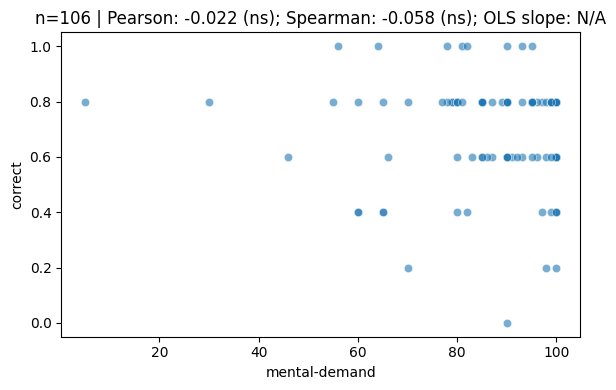

n=106. Pearson r=-0.022 (ns); Spearman ρ=-0.058 (ns); OLS slope=N/A.


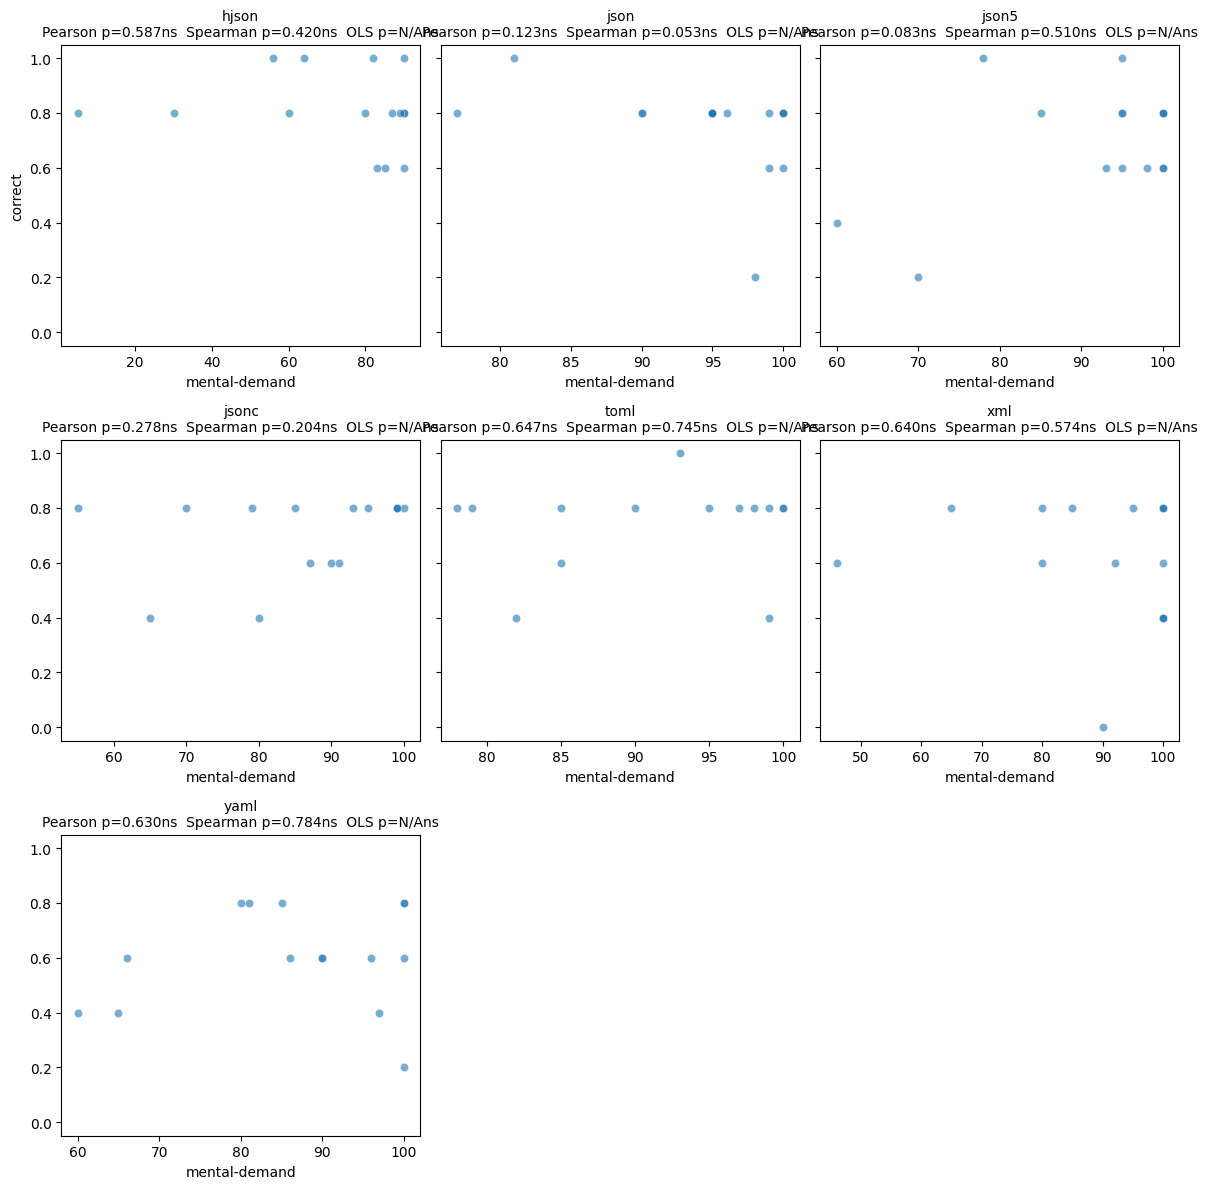

  format                                     interpretation
0  hjson  Pearson r=-0.153 (p=0.587ns); Spearman ρ=-0.22...
1   json  Pearson r=-0.389 (p=0.123ns); Spearman ρ=-0.47...
2  json5  Pearson r=0.462 (p=0.083ns); Spearman ρ=0.185 ...
3  jsonc  Pearson r=0.299 (p=0.278ns); Spearman ρ=0.348 ...
4   toml  Pearson r=0.134 (p=0.647ns); Spearman ρ=0.095 ...
5    xml  Pearson r=-0.132 (p=0.640ns); Spearman ρ=-0.15...
6   yaml  Pearson r=0.136 (p=0.630ns); Spearman ρ=0.077 ...


In [112]:
# df_nasa
# df_quiz_summary
# df_reading_agg_all=df_reading_agg_all[df_reading_agg_all['task'] == 'reading-task-tabular']
# df_reading_agg_all

df_sum = analyze_metric_vs_correct(
    df_metric  = df_nasa,
    df_correct = df_reading_agg_all,
    metric_col = 'mental-demand',
    correct_col= 'correct'
)

print(df_sum['interpretation'].iloc[0])

# 按 format 子图检验
df_sum_fmt = analyze_metric_vs_correct_by_format(
    df_metric  = df_nasa,
    df_correct = df_reading_agg_all,
    metric_col = 'mental-demand',
    correct_col= 'correct'
)
print(df_sum_fmt[['format','interpretation']])

In [113]:
for fmt, text in zip(df_sum_fmt['format'], df_sum_fmt['interpretation']):
    print(f"{fmt}:")
    print(text)
    print('-'*80)

hjson:
Pearson r=-0.153 (p=0.587ns); Spearman ρ=-0.225 (p=0.420ns); Slope=N/A (p=N/Ans)
--------------------------------------------------------------------------------
json:
Pearson r=-0.389 (p=0.123ns); Spearman ρ=-0.478 (p=0.053ns); Slope=N/A (p=N/Ans)
--------------------------------------------------------------------------------
json5:
Pearson r=0.462 (p=0.083ns); Spearman ρ=0.185 (p=0.510ns); Slope=N/A (p=N/Ans)
--------------------------------------------------------------------------------
jsonc:
Pearson r=0.299 (p=0.278ns); Spearman ρ=0.348 (p=0.204ns); Slope=N/A (p=N/Ans)
--------------------------------------------------------------------------------
toml:
Pearson r=0.134 (p=0.647ns); Spearman ρ=0.095 (p=0.745ns); Slope=N/A (p=N/Ans)
--------------------------------------------------------------------------------
xml:
Pearson r=-0.132 (p=0.640ns); Spearman ρ=-0.158 (p=0.574ns); Slope=N/A (p=N/Ans)
-----------------------------------------------------------------------------